# Imports



In [273]:
print(pd.__version__)

1.1.4


In [1]:
# General imports
import os
import sys
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)
import scipy

pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import subprocess

from sklearn.cluster import KMeans

from tqdm import tqdm
# Other imports
tqdm.pandas()

import json

from pprint import pprint

# Custom utils
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from utils.utils import load_config_file

# Figures imports
import matplotlib

from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches

import random 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager
import string

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=20, progress_bar=True)

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/gene_isoforms/src/config/config_files.yaml")
base_dir = yaml['base_directory']

dicts = json.load(open("/home/weber/PycharmProjects/EXOTIC/src/EXOTIC_config.json"))


# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'
rcParams['axes.facecolor'] = 'white'


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:55: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


# RefSeq complete DF

In [4]:
yaml["1_GENOMICS"]["Final"]["refseq_cds_without_variable"]

'refseq_38_processed_cds.parquet'

# A - Define Miso & Siso

In [852]:
refseq_genes = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_pc_genes"])
refseq_genes['Gene_length'] = refseq_genes['End'] - refseq_genes['Start']
# refseq_genes['Gene'] = refseq_genes['Attributes'].apply(lambda r: [e.replace('Name=', '') for e in r.split(';') if 'Name' in e][0])
refseq_genes['Gene'] = refseq_genes['Attributes'].apply(lambda r: [e.replace('ID=gene-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_genes


refseq_mrna = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_mrnas"])
refseq_mrna['Gene'] = refseq_mrna['Attributes'].apply(lambda r: [e.replace('Parent=gene-', '') for e in r.split(';') if 'Parent' in e][0])
refseq_mrna = pd.merge(refseq_genes[['Gene']], refseq_mrna, on='Gene')
refseq_mrna['NM'] = refseq_mrna['Attributes'].apply(lambda r: [e.replace('ID=rna-', '') for e in r.split(';') if 'ID=' in e][0])

miso_siso = refseq_mrna.groupby('Gene')['NM'].nunique().reset_index()
miso_siso.loc[miso_siso['NM'] > 1, 'Miso_siso'] = 'Miso'
miso_siso.loc[miso_siso['NM'] == 1, 'Miso_siso'] = 'Siso'
miso_siso

,Gene,NM,Miso_siso
0,A1BG,1,Siso
1,A1CF,8,Miso
2,A2M,4,Miso
3,A2ML1,2,Miso
4,A3GALT2,1,Siso
...,...,...,...
19280,ZYG11A,2,Miso
19281,ZYG11B,1,Siso
19282,ZYX,3,Miso
19283,ZZEF1,1,Siso


# B - Gene & mRNA level

In [874]:
def describe(df):
    d = df.describe()
    d.loc['Sum'] = df.sum()
    return d

def describe_dev(df, complete_df):
#     print(complete_df)
    d = df.describe()
    d.loc['Sum'] = df.sum()
#     print(d)
#     d['Diff%'] = 100 * (d['Miso'] - d['Siso']) / d['Siso']

    index = df.index[df == df.min()]
    
#     print(complete_df.loc[df.index[df == df.min()]].tolist())
#     else:
            
    minvalue = complete_df.loc[df.index[df == df.min()]]['Gene'].values.tolist()[0]
#     print(minvalue)
                               
    d['Min (Gene)'] = "{:,.2f}".format(d.loc['min']) + '({})'.format(minvalue)

    
    minvalue = complete_df.loc[df.index[df == df.max()]]['Gene'].values.tolist()[0]
    d['Max (Gene)'] = "{:,.2f}".format(d.loc['max']) + '({})'.format(minvalue)
    
    d = d.drop(['min' ,  'max'])
    
#     print(d)

    return d

pd.options.display.float_format = '{:,.2f}'.format






refseq_genes = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_pc_genes"])
refseq_genes['Gene_length'] = refseq_genes['End'] - refseq_genes['Start'] + 1
# refseq_genes['Gene'] = refseq_genes['Attributes'].apply(lambda r: [e.replace('Name=', '') for e in r.split(';') if 'Name' in e][0])
refseq_genes['Gene'] = refseq_genes['Attributes'].apply(lambda r: [e.replace('ID=gene-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_genes = pd.merge(refseq_genes, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_genes

refseq_genes_stats = pd.DataFrame(refseq_genes.groupby('Miso_siso')['Gene_length'].apply(lambda df: describe_dev(df, refseq_genes))).reset_index().pivot(index='level_1', columns='Miso_siso', values='Gene_length')
# refseq_genes_stats['Diff%'] = 100 * (refseq_genes_stats['Miso'] - refseq_genes_stats['Siso']) / refseq_genes_stats['Siso']

mwu = scipy.stats.mannwhitneyu(
        refseq_genes.loc[refseq_genes['Miso_siso'] == 'Miso']['Gene_length'],
        refseq_genes.loc[refseq_genes['Miso_siso'] == 'Siso']['Gene_length'],
)[1]
mwu = '{:0.3e}'.format(mwu)


refseq_genes_stats.columns = pd.MultiIndex.from_product([['Gene length'], ['Miso', 'Siso']])
refseq_genes_stats.index.name = 'Statistics'
refseq_genes_stats.loc['p-value (MWU)'] = mwu



refseq_exons_utr = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_exons"])
refseq_exons_utr['RNA_name'] = refseq_exons_utr['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent' in e][0])
refseq_exons_utr['Length'] = refseq_exons_utr['End'] - refseq_exons_utr['Start'] + 1
refseq_exons_utr['Gene'] = refseq_exons_utr['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons_utr = pd.merge(refseq_exons_utr, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')

refseq_exons_utr_stats_raw = refseq_exons_utr.groupby(['Miso_siso', 'Gene', 'RNA_name'])['Length'].sum().reset_index()

refseq_exons_utr_stats = pd.DataFrame(refseq_exons_utr_stats_raw.groupby('Miso_siso')['Length'].apply(lambda r: describe_dev(r, refseq_exons_utr_stats_raw)).T).reset_index().pivot(index='level_1', columns='Miso_siso', values='Length')
# refseq_exons_utr_stats['Diff%'] = 100 * (refseq_exons_utr_stats['Miso'] - refseq_exons_utr_stats['Siso']) / refseq_exons_utr_stats['Siso']

mwu = scipy.stats.mannwhitneyu(
        refseq_exons_utr_stats_raw.loc[refseq_exons_utr_stats_raw['Miso_siso'] == 'Miso']['Length'],
        refseq_exons_utr_stats_raw.loc[refseq_exons_utr_stats_raw['Miso_siso'] == 'Siso']['Length'],
)[1]
mwu = '{:0.3e}'.format(mwu)

refseq_exons_utr_stats.loc['p-value (MWU)'] = mwu
refseq_exons_utr_stats.columns = pd.MultiIndex.from_product([['Isoforms length'], ['Miso', 'Siso']])
refseq_exons_utr_stats.index.name = 'Statistics'


refseq_mrna = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_mrnas"])
refseq_mrna['RNA_length'] = refseq_mrna['End'] - refseq_mrna['Start'] + 1
refseq_mrna['RNA_name'] = refseq_mrna['Attributes'].apply(lambda r: [e.replace('Name=', '') for e in r.split(';') if 'Name' in e][0])
refseq_mrna['Gene'] = refseq_mrna['Attributes'].apply(lambda r: [e.replace('Parent=gene-', '') for e in r.split(';') if 'Parent' in e][0])
refseq_mrna = pd.merge(refseq_mrna, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')

# refseq_mrna.groupby(['Miso_siso', 'Gene'])['RNA_name'].count().groupby('Miso_siso').apply(lambda r: describe_dev(r, ['sum'], refseq_mrna))
refseq_mrna_stats_raw = refseq_mrna.groupby(['Miso_siso', 'Gene'])['RNA_name'].count().reset_index()
refseq_mrna_stats = pd.DataFrame(refseq_mrna_stats_raw.groupby('Miso_siso')['RNA_name'].apply(lambda r: describe_dev(r, refseq_mrna_stats_raw))).reset_index().pivot(index='level_1', columns='Miso_siso', values='RNA_name')
# refseq_mrna_stats['Diff%'] = 100 * (refseq_mrna_stats['Miso'] - refseq_mrna_stats['Siso']) / refseq_mrna_stats['Siso']

mwu = scipy.stats.mannwhitneyu(
        refseq_mrna_stats_raw.loc[refseq_mrna_stats_raw['Miso_siso'] == 'Miso']['RNA_name'],
        refseq_mrna_stats_raw.loc[refseq_mrna_stats_raw['Miso_siso'] == 'Siso']['RNA_name'],
)[1]
mwu = '{:0.3e}'.format(mwu)

refseq_mrna_stats.loc['p-value (MWU)'] = mwu

refseq_mrna_stats.columns = pd.MultiIndex.from_product([['Isoforms distribution'], ['Miso', 'Siso']])
refseq_mrna_stats.index.name = 'Statistics'

concat_gene_iso_level = pd.concat([refseq_genes_stats, refseq_mrna_stats, refseq_exons_utr_stats], axis=1)
concat_gene_iso_level.index.name = ""
concat_gene_iso_level.to_excel('/gstock/GeneIso/results/1_stats_gene_iso.xlsx')
concat_gene_iso_level.to_excel('/gstock/GeneIso/results/GeneIso.xlsx', sheet_name='1_Gene_level')
concat_gene_iso_level

Gene length                         \
                               Miso                   Siso   
                                                             
25%                       14,737.25               4,771.00   
50%                       35,667.00              14,203.00   
75%                       88,363.75              42,009.00   
Max (Gene)     2,473,592.00(RBFOX1)  2,304,792.00(CNTNAP2)   
Min (Gene)            675.00(IQCF6)           180.00(ETDC)   
Sum                  945,964,881.00         334,374,916.00   
count                     11,368.00               7,917.00   
mean                      83,212.96              42,235.05   
std                      149,013.44              96,239.34   
p-value (MWU)             0.000e+00              0.000e+00   

              Isoforms distribution              Isoforms length  \
                               Miso        Siso             Miso   
                                                                   
25%                            2.00        1.00         2,136.00   
50%                            3.00        1.00         3,333.00   
75%                            5.00        1.00         5,049.00   
Max (Gene)             144.00(MAP4)  1.00(A1BG)  109,224.00(TTN)   
Min (Gene)              2.00(A2ML1)  1.00(A1BG)  235.00(DEFB110)   
Sum                       54,354.00    7,917.00   217,114,384.00   
count                     11,368.00    7,917.00        54,354.00   
mean                           4.78        1.00         3,994.45   
std                            5.98        0.00         2,918.83   
p-value (MWU)             0.000e+00   0.000e+00       1.174e-207   

                                 
                           Siso  
                                 
25%                    1,430.00  
50%                    2,493.00  
75%                    4,298.00  
Max (Gene)     43,816.00(MUC16)  
Min (Gene)         180.00(ETDC)  
Sum               26,086,221.00  
count                  7,917.00  
mean                   3,294.96  
std                    2,766.89  
p-value (MWU)        1.174e-207

In [339]:
mwu = scipy.stats.mannwhitneyu(
        mannwhitneyu_df.loc[mannwhitneyu_df['Miso_siso'] == 'Miso']['Length'],
        mannwhitneyu_df.loc[mannwhitneyu_df['Miso_siso'] == 'Siso']['Length'],
)[1]
mwu = '{:0.3e}'.format(mwu)
mwu

# refseq_exons_utr.groupby(['Miso_siso', 'Gene', 'RNA_name'])['Length'].sum().reset_index()

'3.716e-206'

# C - Exon, CDS, Intron level

## Length level

In [ ]:
def describe_dev(df,col):
    col = col[0]
    d = df[col].describe().T
    d.loc['Sum'] = df[col].sum()
    d['%Diff'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
#     d.loc['MWU p-value'] = scipy.stats.mannwhitneyu(df.obj.loc['Miso'][col].values, df.obj.loc['Siso'][col].values)[1]
    return d

refseq_exons = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_exons"])
refseq_exons['Length'] = refseq_exons['End'] - refseq_exons['Start'] + 1

refseq_exons['Gene'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons = pd.merge(refseq_exons, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')

refseq_cds = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_cds"])
refseq_cds['Length'] = refseq_cds['End'] - refseq_cds['Start'] + 1

refseq_cds['Gene'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_cds = pd.merge(refseq_cds, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_cds = refseq_cds.loc[refseq_cds['Length'] > 0]

stats_exons_length = pd.concat(
    [
        describe_dev(refseq_exons.groupby(['Miso_siso']),['Length']),
        describe_dev(refseq_exons.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso']),['Length']),
        describe_dev(refseq_cds.groupby(['Miso_siso']),['Length']),
        describe_dev(refseq_cds.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso']),['Length']),        
    ], axis=1
)

stats_exons_length.columns = pd.MultiIndex.from_product([['Length'], ['Exons', 'Exons NR', 'Coding exons', 'Coding exons NR'], ['Miso', 'Siso', '%Diff']])
stats_exons_length.index.name = 'Statistics'
# stats_exons_length

## Distri level

In [ ]:
def describe_dev(df):
#     print(df.obj)
    d = df.describe().T
    d.loc['Sum'] = df.sum()
    d['%Diff'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
#     d.loc['MWU p-value'] = scipy.stats.mannwhitneyu(df.obj.loc['Miso'].values, df.obj.loc['Siso'].values)[1]
    return d

refseq_exons = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_exons"])
refseq_exons['Length'] = refseq_exons['End'] - refseq_exons['Start']

refseq_exons['Gene'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons = pd.merge(refseq_exons, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')

refseq_cds = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_cds"])
refseq_cds['Length'] = refseq_cds['End'] - refseq_cds['Start']

refseq_cds['Gene'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_cds = pd.merge(refseq_cds, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')

stats_exons_distri = pd.concat(
    [
        describe_dev(refseq_exons.groupby(['Miso_siso', 'Gene'])['Start'].count().rename('Count').groupby('Miso_siso')),
        describe_dev(refseq_exons.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso', 'Gene'])['Start'].count().rename('Count').groupby('Miso_siso')),
        describe_dev(refseq_cds.groupby(['Miso_siso', 'Gene'])['Start'].count().rename('Count').groupby('Miso_siso')),
        describe_dev(refseq_cds.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso', 'Gene'])['Start'].count().rename('Count').groupby('Miso_siso')),        
    ], axis=1
)

stats_exons_distri.columns = pd.MultiIndex.from_product([['Distribution'], ['Exons', 'Exons NR', 'Coding exons', 'Coding exons NR'], ['Miso', 'Siso', "%Diff"]])
stats_exons_distri.index.name = 'Statistics'
# stats_exons_distri

In [632]:
pd.concat([stats_exons_length, stats_exons_distri], axis=1).T

Statistics                              count   mean    std    min    25%  \
Length       Exons           Miso  676,665.00 320.86 885.47   2.00  90.00   
                             Siso   67,512.00 386.39 957.49   3.00  97.00   
                             %Diff      90.02 -20.42  -8.13 -50.00  -7.78   
             Exons NR        Miso  167,375.00 350.56 902.82   2.00  93.00   
                             Siso   67,471.00 386.39 957.63   3.00  97.00   
                             %Diff      59.69 -10.22  -6.07 -50.00  -4.30   
             Coding exons    Miso  609,022.00 155.92 232.92   1.00  83.00   
                             Siso   64,339.00 194.22 363.23   1.00  90.00   
                             %Diff      89.44 -24.56 -55.94   0.00  -8.43   
             Coding exons NR Miso  150,560.00 162.49 260.62   1.00  81.00   
                             Siso   64,300.00 194.21 363.30   1.00  90.00   
                             %Diff      57.29 -19.52 -39.40   0.00 -11.11   
Distribution Exons           Miso   11,356.00  59.59 121.64   2.00  16.00   
                             Siso    7,911.00   8.53  10.31   1.00   3.00   
                             %Diff      30.34  85.68  91.53  50.00  81.25   
             Exons NR        Miso   11,356.00  14.74  10.92   1.00   8.00   
                             Siso    7,911.00   8.53  10.31   1.00   3.00   
                             %Diff      30.34  42.13   5.62   0.00  62.50   
             Coding exons    Miso   11,356.00  53.63 112.17   2.00  13.00   
                             Siso    7,911.00   8.13  10.28   1.00   2.00   
                             %Diff      30.34  84.84  90.84  50.00  84.62   
             Coding exons NR Miso   11,356.00  13.26  10.87   1.00   6.00   
                             Siso    7,911.00   8.13  10.27   1.00   2.00   
                             %Diff      30.34  38.70   5.52   0.00  66.67   

Statistics                            50%    75%       max            Sum  
Length       Exons           Miso  128.00 186.00 35,596.00 217,114,384.00  
                             Siso  138.00 209.00 27,303.00  26,086,221.00  
                             %Diff  -7.81 -12.37     23.30          87.99  
             Exons NR        Miso  134.00 204.00 35,596.00  58,674,910.00  
                             Siso  138.00 209.00 27,303.00  26,070,440.00  
                             %Diff  -2.99  -2.45     23.30          55.57  
             Coding exons    Miso  119.00 165.00 17,331.00  94,959,290.00  
                             Siso  128.00 178.00 21,693.00  12,495,879.00  
                             %Diff  -7.56  -7.88    -25.17          86.84  
             Coding exons NR Miso  119.00 167.00 17,331.00  24,464,440.00  
                             Siso  128.00 178.00 21,693.00  12,487,542.00  
                             %Diff  -7.56  -6.59    -25.17          48.96  
Distribution Exons           Miso   30.00  60.00  4,108.00     676,665.00  
                             Siso    5.00  11.00    172.00      67,512.00  
                             %Diff  83.33  81.67     95.81          90.02  
             Exons NR        Miso   12.00  19.00    364.00     167,375.00  
                             Siso    5.00  11.00    172.00      67,471.00  
                             %Diff  58.33  42.11     52.75          59.69  
             Coding exons    Miso   27.00  55.00  3,819.00     609,022.00  
                             Siso    5.00  10.00    172.00      64,339.00  
                             %Diff  81.48  81.82     95.50          89.44  
             Coding exons NR Miso   11.00  17.00    363.00     150,560.00  
                             Siso    5.00  10.00    172.00      64,300.00  
                             %Diff  54.55  41.18     52.62          57.29

In [ ]:
mwu = scipy.stats.mannwhitneyu(
        refseq_exons_utr_stats_raw.loc[refseq_exons_utr_stats_raw['Miso_siso'] == 'Miso']['Length'],
        refseq_exons_utr_stats_raw.loc[refseq_exons_utr_stats_raw['Miso_siso'] == 'Siso']['Length'],
)[1]
mwu = '{:0.3e}'.format(mwu)

In [876]:
stats_exons_distri

Distribution                                             \
                  Exons                   Exons NR                   
                   Miso      Siso %Diff       Miso      Siso %Diff   
Statistics                                                           
count         11,356.00  7,911.00 30.34  11,356.00  7,911.00 30.34   
mean              59.59      8.53 85.68      14.74      8.53 42.13   
std              121.64     10.31 91.53      10.92     10.31  5.62   
min                2.00      1.00 50.00       1.00      1.00  0.00   
25%               16.00      3.00 81.25       8.00      3.00 62.50   
50%               30.00      5.00 83.33      12.00      5.00 58.33   
75%               60.00     11.00 81.67      19.00     11.00 42.11   
max            4,108.00    172.00 95.81     364.00    172.00 52.75   
Sum          676,665.00 67,512.00 90.02 167,375.00 67,471.00 59.69   

                                                                         
           Coding exons                 Coding exons NR                  
                   Miso      Siso %Diff            Miso      Siso %Diff  
Statistics                                                               
count         11,356.00  7,911.00 30.34       11,356.00  7,911.00 30.34  
mean              53.63      8.13 84.84           13.26      8.13 38.70  
std              112.17     10.28 90.84           10.87     10.27  5.52  
min                2.00      1.00 50.00            1.00      1.00  0.00  
25%               13.00      2.00 84.62            6.00      2.00 66.67  
50%               27.00      5.00 81.48           11.00      5.00 54.55  
75%               55.00     10.00 81.82           17.00     10.00 41.18  
max            3,819.00    172.00 95.50          363.00    172.00 52.62  
Sum          609,022.00 64,339.00 89.44      150,560.00 64,300.00 57.29

## Intron based on all exons (with UTR)

In [626]:

refseq_exons_utr = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_exons"])
refseq_exons_utr['RNA_name'] = refseq_exons_utr['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent' in e][0])
refseq_exons_utr['Length'] = refseq_exons_utr['End'] - refseq_exons_utr['Start'] + 1
refseq_exons_utr['Gene'] = refseq_exons_utr['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons_utr['ranges'] = refseq_exons_utr['Start'].astype(str) + '-' + refseq_exons_utr['End'].astype(str)
refseq_exons_utr.loc[refseq_exons_utr['RNA_name'].str.contains('-2'), 'Gene'] = refseq_exons_utr.loc[refseq_exons_utr['RNA_name'].str.contains('-2'), 'Gene'] + '-2'


refseq_exons_utr_gb_exons = pd.merge(refseq_exons_utr.sort_values(by=['Gene', 'RNA_name', 'Start']).groupby(['Gene','RNA_name'])['ranges'].apply(list).reset_index(), miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_exons_utr_introns = refseq_exons_utr_gb_exons.groupby(['Gene', 'RNA_name']).progress_apply(get_introns)
refseq_exons_utr_introns_exploded = refseq_exons_utr_introns.explode('Introns')
refseq_exons_utr_introns_exploded[['Intron_Start', 'Intron_End']] = refseq_exons_utr_introns_exploded.Introns.str.split('-', expand=True)
refseq_exons_utr_introns_exploded = refseq_exons_utr_introns_exploded.dropna(subset=['Intron_Start'])
refseq_exons_utr_introns_exploded[['Intron_Start', 'Intron_End']] = refseq_exons_utr_introns_exploded[['Intron_Start', 'Intron_End']].astype(int)
refseq_exons_utr_introns_exploded['Intron_Length'] = refseq_exons_utr_introns_exploded['Intron_End'] - refseq_exons_utr_introns_exploded['Intron_Start'] + 1
refseq_exons_utr_introns_exploded
# refseq_exons_utr


def describe_dev(df):
#     print(df.obj)
    d = df.describe().T
#     print(d)
    d.loc['Sum'] = df.sum()
    d['%Diff'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
#     d.loc['MWU p-value'] = scipy.stats.mannwhitneyu(df.obj.loc['Miso'].values, df.obj.loc['Siso'].values)[1]
    return d

stats_intron_exons_utr = pd.concat(
    [
        describe_dev(refseq_exons_utr_introns_exploded[['Miso_siso', 'Intron_Length']].groupby(['Miso_siso'])['Intron_Length']),
        describe_dev(refseq_exons_utr_introns_exploded[['Miso_siso', 'Gene', 'Intron_Length', 'Intron_Start', 'Intron_End']].drop_duplicates(subset=['Gene', 'Intron_Start', 'Intron_Length']).groupby(['Miso_siso'])['Intron_Length']),
    ], 
    axis=1
)

100%|██████████| 62271/62271 [00:49<00:00, 1265.41it/s]


In [621]:
refseq_exons_utr_introns_exploded_dd = refseq_exons_utr_introns_exploded.drop_duplicates(subset=['Gene', 'Intron_Start', 'Intron_Length'])
scipy.stats.mannwhitneyu(refseq_exons_utr_introns_exploded_dd.loc[refseq_exons_utr_introns_exploded_dd['Miso_siso'] == 'Miso', 'Intron_Length'].values, refseq_exons_utr_introns_exploded_dd.loc[refseq_exons_utr_introns_exploded_dd['Miso_siso'] == 'Siso', 'Intron_Length'].values)[1]

0.0

## Intron based on coding exons (withOUT UTR)

In [645]:
refseq_cds = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_cds"])
refseq_cds['Length'] = refseq_cds['End'] - refseq_cds['Start'] + 1
refseq_cds = refseq_cds.loc[refseq_cds['Length'] > 0] 
refseq_cds['Gene'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_cds['NP'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('ID=cds-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] = refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] + '-2'
refseq_cds = pd.merge(refseq_cds, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_cds[['Start', 'End']] = refseq_cds[['Start', 'End']].astype(int)
refseq_cds['ranges'] = refseq_cds['Start'].astype(str) + '-' + refseq_cds['End'].astype(str)

refseq_cds_gb_exons = pd.merge(refseq_cds.sort_values(by=['Gene', 'NP', 'Start']).groupby(['Gene','NP'])['ranges'].apply(list).reset_index(), miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_cds_introns = refseq_cds_gb_exons.groupby(['Gene', 'NP']).progress_apply(get_introns)
refseq_cds_introns_exploded = refseq_cds_introns.explode('Introns')
refseq_cds_introns_exploded[['Intron_Start', 'Intron_End']] = refseq_cds_introns_exploded.Introns.str.split('-', expand=True)
refseq_cds_introns_exploded = refseq_cds_introns_exploded.dropna(subset=['Intron_Start'])
refseq_cds_introns_exploded[['Intron_Start', 'Intron_End']] = refseq_cds_introns_exploded[['Intron_Start', 'Intron_End']].astype(int)
refseq_cds_introns_exploded['Intron_Length'] = refseq_cds_introns_exploded['Intron_End'] - refseq_cds_introns_exploded['Intron_Start'] + 1
refseq_cds_introns_exploded
# refseq_cds


def describe_dev(df):
#     print(df.obj)
    d = df.describe().T
#     print(d)
    d.loc['Sum'] = df.sum()
    d['%Diff'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
#     d.loc['MWU p-value'] = scipy.stats.mannwhitneyu(df.obj.loc['Miso'].values, df.obj.loc['Siso'].values)[1]
    return d

stats_intron_cds = pd.concat(
    [
        describe_dev(refseq_cds_introns_exploded[['Miso_siso', 'Intron_Length']].groupby(['Miso_siso'])['Intron_Length']),
        describe_dev(refseq_cds_introns_exploded[['Miso_siso', 'Gene', 'Intron_Length', 'Intron_Start', 'Intron_End']].drop_duplicates().groupby(['Miso_siso'])['Intron_Length']),
    ], 
    axis=1
)

In [646]:
concat_stats_intron = pd.concat([stats_intron_exons_utr, stats_intron_cds], axis=1)
concat_stats_intron.columns = pd.MultiIndex.from_product([['Length - Intron/Exons', 'Length -Intron/CDS'], ['All', 'NR'], ['Miso', 'Siso', '%Diff']])
concat_stats_intron

Length - Intron/Exons                                         \
                        All                                     NR   
                       Miso           Siso  %Diff             Miso   
count            622,311.00      59,595.00  90.42       166,563.00   
mean               7,398.06       4,827.80  34.74         8,546.81   
std               23,380.81      16,552.32  29.21        26,921.76   
min                    1.00           0.00 100.00             1.00   
25%                  620.00         450.00  27.42           640.00   
50%                1,834.00       1,344.00  26.72         1,971.00   
75%                5,126.00       3,540.50  30.93         5,878.00   
max            1,160,411.00     740,920.00  36.15     1,160,411.00   
Sum        4,603,891,866.00 287,712,609.00  93.75 1,423,582,883.00   

                            Length -Intron/CDS                        \
                                           All                         
                Siso  %Diff               Miso           Siso  %Diff   
count      59,595.00  64.22         554,668.00      56,422.00  89.83   
mean        4,827.80  43.51           6,400.10       4,585.08  28.36   
std        16,552.32  38.52          21,431.67      16,266.58  24.10   
min             0.00 100.00              -1.00           0.00 100.00   
25%           450.00  29.69             591.00         435.00  26.40   
50%         1,344.00  31.81           1,721.00       1,308.00  24.00   
75%         3,540.50  39.77           4,561.00       3,407.00  25.30   
max       740,920.00  36.15       1,160,411.00     740,920.00  36.15   
Sum   287,712,609.00  79.79   3,549,929,469.00 258,699,156.00  92.71   

                                            
                  NR                        
                Miso           Siso  %Diff  
count     139,171.00      56,422.00  59.46  
mean        7,109.89       4,585.08  35.51  
std        24,503.20      16,266.58  33.61  
min            -1.00           0.00 100.00  
25%           587.00         435.00  25.89  
50%         1,784.00       1,308.00  26.68  
75%         4,908.00       3,407.00  30.58  
max     1,160,411.00     740,920.00  36.15  
Sum   989,491,114.00 258,699,156.00  73.86

In [827]:
concat_exon_level = pd.concat(
    [
        pd.concat([stats_exons_length, stats_exons_distri], axis=1).T,
        concat_stats_intron.T
    ]
)
concat_exon_level.to_excel('/gstock/GeneIso/results/2B_exon_cds_intron_length_distri.xlsx')
concat_exon_level

Statistics                                       count     mean       std  \
Length                Exons           Miso  676,665.00   320.86    885.47   
                                      Siso   67,512.00   386.39    957.49   
                                      %Diff      90.02   -20.42     -8.13   
                      Exons NR        Miso  167,375.00   350.56    902.82   
                                      Siso   67,471.00   386.39    957.63   
                                      %Diff      59.69   -10.22     -6.07   
                      Coding exons    Miso  609,022.00   155.92    232.92   
                                      Siso   64,339.00   194.22    363.23   
                                      %Diff      89.44   -24.56    -55.94   
                      Coding exons NR Miso  150,560.00   162.49    260.62   
                                      Siso   64,300.00   194.21    363.30   
                                      %Diff      57.29   -19.52    -39.40   
Distribution          Exons           Miso   11,356.00    59.59    121.64   
                                      Siso    7,911.00     8.53     10.31   
                                      %Diff      30.34    85.68     91.53   
                      Exons NR        Miso   11,356.00    14.74     10.92   
                                      Siso    7,911.00     8.53     10.31   
                                      %Diff      30.34    42.13      5.62   
                      Coding exons    Miso   11,356.00    53.63    112.17   
                                      Siso    7,911.00     8.13     10.28   
                                      %Diff      30.34    84.84     90.84   
                      Coding exons NR Miso   11,356.00    13.26     10.87   
                                      Siso    7,911.00     8.13     10.27   
                                      %Diff      30.34    38.70      5.52   
Length - Intron/Exons All             Miso  622,311.00 7,398.06 23,380.81   
                                      Siso   59,595.00 4,827.80 16,552.32   
                                      %Diff      90.42    34.74     29.21   
                      NR              Miso  166,563.00 8,546.81 26,921.76   
                                      Siso   59,595.00 4,827.80 16,552.32   
                                      %Diff      64.22    43.51     38.52   
Length -Intron/CDS    All             Miso  554,668.00 6,400.10 21,431.67   
                                      Siso   56,422.00 4,585.08 16,266.58   
                                      %Diff      89.83    28.36     24.10   
                      NR              Miso  139,171.00 7,109.89 24,503.20   
                                      Siso   56,422.00 4,585.08 16,266.58   
                                      %Diff      59.46    35.51     33.61   

Statistics                                     min    25%      50%      75%  \
Length                Exons           Miso    2.00  90.00   128.00   186.00   
                                      Siso    3.00  97.00   138.00   209.00   
                                      %Diff -50.00  -7.78    -7.81   -12.37   
                      Exons NR        Miso    2.00  93.00   134.00   204.00   
                                      Siso    3.00  97.00   138.00   209.00   
                                      %Diff -50.00  -4.30    -2.99    -2.45   
                      Coding exons    Miso    1.00  83.00   119.00   165.00   
                                      Siso    1.00  90.00   128.00   178.00   
                                      %Diff   0.00  -8.43    -7.56    -7.88   
                      Coding exons NR Miso    1.00  81.00   119.00   167.00   
                                      Siso    1.00  90.00   128.00   178.00   
                                      %Diff   0.00 -11.11    -7.56    -6.59   
Distribution          Exons           Miso    2.00  16.00    30.00    60.00   
                                      Siso  

# D - compute overlap

In [997]:
test_df_cds = pd.DataFrame([

    {
        'Start' : 7,
        'End' : 8,
        'ID' : 'A',
        'Gene' : 'AAA',
        'mRNA' : '1',
    },
    {
        'Start' : 10,
        'End' : 13,
        'ID' : 'A',
        'Gene' : 'AAA',
        'mRNA' : '1',
    },    
    {
        'Start' : 8,
        'End' : 10,
        'ID' : 'B',
        'Gene' : 'AAA',
        'mRNA' : '2',
    },
    
    {
        'Start' : 18,
        'End' : 20,
        'ID' : 'D',
        'Gene' : 'AAA',        
        'mRNA' : '1',        
    },    
    {
        'Start' : 20,
        'End' : 22,
        'ID' : 'D',
        'Gene' : 'AAA',        
        'mRNA' : '2',        
    },        
#     {
#         'Start' : 7,
#         'End' : 8,
#         'ID' : 'D',
#         'Gene' : 'AAA',        
#     },    
#     {
#         'Start' : 3,
#         'End' : 4,
#         'ID' : 'D',
#         'Gene' : 'BBB',       
#         'mRNA' : '1',        
        
#     },
#     {
#         'Start' : 10,
#         'End' : 15,
#         'ID' : 'D',
#         'Gene' : 'BBB',     
#         'mRNA' : '1',        
        
#     },    
])
test_df_cds['ranges'] = test_df_cds['Start'].astype(str) + '-' + test_df_cds['End'].astype(str)
test_df_cds['Type'] = 'CDS'
test_df_cds = test_df_cds.sort_values(by=['Gene', 'mRNA', 'Start'])
test_df_cds

,Start,End,ID,Gene,mRNA,ranges,Type
0,7,8,A,AAA,1,7-8,CDS
1,10,13,A,AAA,1,10-13,CDS
3,18,20,D,AAA,1,18-20,CDS
2,8,10,B,AAA,2,8-10,CDS
4,20,22,D,AAA,2,20-22,CDS


In [1137]:
test_df_exon = pd.DataFrame([

    {
        'Start' : 5,
        'End' : 8,
        'ID' : 'A',
        'Gene' : 'AAA',
        'mRNA' : '1',
    },
    {
        'Start' : 1,
        'End' : 3,
        'ID' : 'A',
        'Gene' : 'AAA',
        'mRNA' : '1',
    },
    {
        'Start' : 10,
        'End' : 13,
        'ID' : 'A',
        'Gene' : 'AAA',
        'mRNA' : '1',
    },    
    {
        'Start' : 1,
        'End' : 10,
        'ID' : 'B',
        'Gene' : 'AAA',
        'mRNA' : '2',
    },
    
    {
        'Start' : 18,
        'End' : 26,
        'ID' : 'D',
        'Gene' : 'AAA',        
        'mRNA' : '1',        
    },    
    {
        'Start' : 20,
        'End' : 26,
        'ID' : 'D',
        'Gene' : 'AAA',        
        'mRNA' : '2',        
    }, 
    {
        'Start' : 30,
        'End' : 36,
        'ID' : 'D',
        'Gene' : 'AAA',        
        'mRNA' : '2',        
    },  
#     {
#         'Start' : 7,
#         'End' : 8,
#         'ID' : 'D',
#         'Gene' : 'AAA',        
#     },    
#     {
#         'Start' : 3,
#         'End' : 4,
#         'ID' : 'D',
#         'Gene' : 'BBB',       
#         'mRNA' : '1',        
        
#     },
#     {
#         'Start' : 10,
#         'End' : 15,
#         'ID' : 'D',
#         'Gene' : 'BBB',     
#         'mRNA' : '1',        
        
#     },    
])
test_df_exon['ranges'] = test_df_exon['Start'].astype(str) + '-' + test_df_exon['End'].astype(str)
test_df_exon['Type'] = 'exon'
test_df_exon

,Start,End,ID,Gene,mRNA,ranges,Type
0,5,8,A,AAA,1,5-8,exon
1,1,3,A,AAA,1,1-3,exon
2,10,13,A,AAA,1,10-13,exon
3,1,10,B,AAA,2,1-10,exon
4,18,26,D,AAA,1,18-26,exon
5,20,26,D,AAA,2,20-26,exon
6,30,36,D,AAA,2,30-36,exon


In [1225]:


def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))



def get_utrs(df):
    if df.Strand.values[0] == "+":
        strand = "+"
        df = df.sort_values(by=['Start', 'End'])

    elif df.Strand.values[0] == "-":
        strand = "-"
        df = df.sort_values(by=['Start', 'End'], ascending=False)
        
    cds = df.loc[df['Type'] == "CDS", 'ranges'].values.tolist()
    exons = df.loc[df['Type'] == "exon", 'ranges'].values.tolist()
    diff_exons = sorted([int(sub_e) for e in list(set(exons).difference(set(cds))) for sub_e in e.split('-')])
    diff_exons = ["{}-{}".format(diff_exons[i], diff_exons[i+1]) for i, e in enumerate(diff_exons) if i % 2 == 0 and i < len(diff_exons) - 1]

    empty_dict = dict()
    utr_dict = dict()
    for j, e in enumerate(diff_exons):
        e = [int(sub_e) for sub_e in e.split('-')]
        for i, c in enumerate(cds):
            c = [int(sub_c) for sub_c in c.split('-')]
            if getOverlap(e,c) > 0:
                if i == 0:

                    if strand == "+":
                        new_e = [e[0], c[0] - 1]
                        utr_dict["5_prime"] = c[0] - 1 
                    elif strand == "-":
                        new_e = [c[1] + 1, e[1]]
                        utr_dict["5_prime"] = c[1] + 1 
   
                    empty_dict["-".join([str(sub_e) for sub_e in e])] = "-".join([str(sub_e) for sub_e in new_e])
                    
                    
                elif i == len(cds) - 1:
                    if strand == "+":
                        new_e = [c[1] + 1, e[1]]
                        utr_dict["3_prime"] = c[1] + 1 
                        
                    elif strand == "-":
                        new_e = [e[0], c[0] - 1]  
                        utr_dict["3_prime"] = c[0] - 1 

                    empty_dict["-".join([str(sub_e) for sub_e in e])] = "-".join([str(sub_e) for sub_e in new_e])
#     print(df['Gene'].values[0], df['RNA_name'].values[0], utr_dict)
    df['UTR_ranges'] = df['ranges'].map(empty_dict)
  


    if strand == "+":
        
        if '5_prime' in utr_dict:
            df.loc[df['End'] < utr_dict['5_prime'], 'UTR_ranges'] = df.loc[df['End'] < utr_dict['5_prime']]['ranges']
            df.loc[df['Start'] < utr_dict['5_prime'], 'UTR_bool'] = "5_prime"

        if '3_prime' in utr_dict:
            df.loc[df['Start'] > utr_dict['3_prime'], 'UTR_ranges'] = df.loc[df['Start'] > utr_dict['3_prime']]['ranges']
            df.loc[df['End'] > utr_dict['3_prime'], 'UTR_bool'] = "3_prime"

    elif strand == "-":
        
        if '5_prime' in utr_dict:
            df.loc[df['End'] > utr_dict['5_prime'], 'UTR_bool'] = "5_prime"
            df.loc[df['Start'] > utr_dict['5_prime'], 'UTR_ranges'] = df.loc[df['End'] > utr_dict['5_prime']]['ranges']
        if '3_prime' in utr_dict:
            df.loc[df['End'] < utr_dict['3_prime'], 'UTR_ranges'] = df.loc[df['Start'] < utr_dict['3_prime']]['ranges']
            df.loc[df['Start'] < utr_dict['3_prime'], 'UTR_bool'] = "3_prime"


    df.loc[df['Type'] == 'CDS', 'Nb_exon'] = list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))
    df.loc[df['Type'] == 'exon', 'Nb_exon'] = list(range(1,df.loc[df['Type'] == 'exon'].shape[0] + 1))
#     df['UTR_length'] = df.apply(lambda r: [int(e) for e in r['UTR_ranges'].split('-')][1] - [int(e) for e in r['UTR_ranges'].split('-')][0], axis=1)
    df.loc[df['Type'] == 'CDS', 'Nb_exon_relative'] = np.array(list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))) + df.loc[df['UTR_bool'] == '5_prime']['Nb_exon'].values[-1] - 1

    return df
            
        
concat_cds_exon = pd.concat(
    [test_df_cds, test_df_exon]
)
concat_cds_exon['Strand'] = '+'
concat_cds_exon = concat_cds_exon.rename({'mRNA' : 'RNA_name'}, axis=1)
concat_cds_exon = concat_cds_exon.groupby(['Gene', 'RNA_name']).apply(lambda df: get_utrs(df))
concat_cds_exon

Start  End ID Gene RNA_name ranges  Type Strand UTR_ranges  \
Gene RNA_name                                                                 
AAA  1        1      1    3  A  AAA        1    1-3  exon      +        1-3   
              0      5    8  A  AAA        1    5-8  exon      +        5-6   
              0      7    8  A  AAA        1    7-8   CDS      +        NaN   
              1     10   13  A  AAA        1  10-13   CDS      +        NaN   
              2     10   13  A  AAA        1  10-13  exon      +        NaN   
              3     18   20  D  AAA        1  18-20   CDS      +        NaN   
              4     18   26  D  AAA        1  18-26  exon      +      21-26   
     2        3      1   10  B  AAA        2   1-10  exon      +        1-7   
              2      8   10  B  AAA        2   8-10   CDS      +        NaN   
              4     20   22  D  AAA        2  20-22   CDS      +        NaN   
              5     20   26  D  AAA        2  20-26  exon      +      23-26   
              6     30   36  D  AAA        2  30-36  exon      +      30-36   

                UTR_bool  Nb_exon  Nb_exon_relative  
Gene RNA_name                                        
AAA  1        1  5_prime     1.00               nan  
              0  5_prime     2.00               nan  
              0      NaN     1.00              2.00  
              1      NaN     2.00              3.00  
              2      NaN     3.00               nan  
              3      NaN     3.00              4.00  
              4  3_prime     4.00               nan  
     2        3  5_prime     1.00               nan  
              2      NaN     1.00              1.00  
              4      NaN     2.00              2.00  
              5  3_prime     2.00               nan  
              6  3_prime     3.00               nan

In [1174]:
test_concat_cds_exons.loc[test_concat_cds_exons['Gene'] == "A3GALT2"].sort_values(by=['Start', 'End', 'RNA_name'], ascending=False)

,NC,RefSeq_validation,Type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,RNA_name,Miso_siso,ranges
14644,NC_000001.11,BestRefSeq,CDS,33321076,33321098,.,-,0,ID=cds-NP_001073907.1;Parent=rna-NM_001080438....,22,A3GALT2,NP_001073907.1,NM_001080438.1,Siso,33321076-33321098
16272,NC_000001.11,BestRefSeq,exon,33321076,33321098,.,-,.,ID=exon-NM_001080438.1-1;Parent=rna-NM_0010804...,23,A3GALT2,NaN,NM_001080438.1,Siso,33321076-33321098
14645,NC_000001.11,BestRefSeq,CDS,33312807,33312890,.,-,1,ID=cds-NP_001073907.1;Parent=rna-NM_001080438....,83,A3GALT2,NP_001073907.1,NM_001080438.1,Siso,33312807-33312890
16273,NC_000001.11,BestRefSeq,exon,33312807,33312890,.,-,.,ID=exon-NM_001080438.1-2;Parent=rna-NM_0010804...,84,A3GALT2,NaN,NM_001080438.1,Siso,33312807-33312890
14646,NC_000001.11,BestRefSeq,CDS,33312501,33312590,.,-,1,ID=cds-NP_001073907.1;Parent=rna-NM_001080438....,89,A3GALT2,NP_001073907.1,NM_001080438.1,Siso,33312501-33312590
16274,NC_000001.11,BestRefSeq,exon,33312501,33312590,.,-,.,ID=exon-NM_001080438.1-3;Parent=rna-NM_0010804...,90,A3GALT2,NaN,NM_001080438.1,Siso,33312501-33312590
14647,NC_000001.11,BestRefSeq,CDS,33312052,33312189,.,-,1,ID=cds-NP_001073907.1;Parent=rna-NM_001080438....,137,A3GALT2,NP_001073907.1,NM_001080438.1,Siso,33312052-33312189
16275,NC_000001.11,BestRefSeq,exon,33312052,33312189,.,-,.,ID=exon-NM_001080438.1-4;Parent=rna-NM_0010804...,138,A3GALT2,NaN,NM_001080438.1,Siso,33312052-33312189
14648,NC_000001.11,BestRefSeq,CDS,33306766,33307453,.,-,1,ID=cds-NP_001073907.1;Parent=rna-NM_001080438....,687,A3GALT2,NP_001073907.1,NM_001080438.1,Siso,33306766-33307453
16276,NC_000001.11,BestRefSeq,exon,33306766,33307453,.,-,.,ID=exon-NM_001080438.1-5;Parent=rna-NM_0010804...,688,A3GALT2,NaN,NM_001080438.1,Siso,33306766-33307453


In [1199]:
test_concat_cds_exons = pd.concat([
    refseq_cds.reset_index(drop=True),
    refseq_exons_utr.reset_index(drop=True)
]).rename({'Region_type' : 'Type'},axis=1)

test_concat_cds_exons = test_concat_cds_exons.sort_values(by=['Gene', 'Start', 'End', 'Type'])
test_concat_cds_exons = test_concat_cds_exons.groupby(['Gene', 'RNA_name']).progress_apply(get_utrs)
test_concat_cds_exons.columns
# get_utrs

100%|██████████| 62271/62271 [27:50<00:00, 37.28it/s]  


Index(['NC', 'RefSeq_validation', 'Type', 'Start', 'End', 'Score', 'Strand',
       'Phase', 'Attributes', 'Length', 'Gene', 'NP', 'RNA_name', 'Miso_siso',
       'ranges', 'UTR_ranges', 'UTR_bool', 'Nb_exon'],
      dtype='object')

In [1226]:
test_concat_cds_exons = test_concat_cds_exons.reset_index(drop=True)
def relative_position(df):
    if '5_prime' in df['UTR_bool'].values.tolist():
        df.loc[df['Type'] == 'CDS', 'Nb_exon_relative'] = np.array(list(range(1,df.loc[df['Type'] == 'CDS'].shape[0] + 1))) + df.loc[df['UTR_bool'] == '5_prime']['Nb_exon'].values[-1] - 1
    else:
        df['Nb_exon_relative'] = df['Nb_exon']
    return df

# test_concat_cds_exons_relative_position = test_concat_cds_exons.groupby(['Gene', 'RNA_name']).progress_apply(relative_position)
test_concat_cds_exons_relative_position['Nb_exon_relative'] = test_concat_cds_exons_relative_position['Nb_exon_relative'] - 1
test_concat_cds_exons_relative_position

,NC,RefSeq_validation,Type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,RNA_name,Miso_siso,ranges,UTR_ranges,UTR_bool,Nb_exon,Nb_exon_relative
0,NC_000019.10,BestRefSeq,exon,58353404,58353492,.,-,.,ID=exon-NM_130786.4-1;Parent=rna-NM_130786.4;D...,89,A1BG,NaN,NM_130786.4,Siso,58353404-58353492,58353438-58353492,5_prime,1.00,nan
1,NC_000019.10,BestRefSeq,CDS,58353404,58353437,.,-,0,ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...,33,A1BG,NP_570602.2,NM_130786.4,Siso,58353404-58353437,NaN,NaN,1.00,1.00
2,NC_000019.10,BestRefSeq,CDS,58353292,58353327,.,-,2,ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...,35,A1BG,NP_570602.2,NM_130786.4,Siso,58353292-58353327,NaN,NaN,2.00,2.00
3,NC_000019.10,BestRefSeq,exon,58353292,58353327,.,-,.,ID=exon-NM_130786.4-2;Parent=rna-NM_130786.4;D...,36,A1BG,NaN,NM_130786.4,Siso,58353292-58353327,NaN,NaN,2.00,nan
4,NC_000019.10,BestRefSeq,CDS,58352928,58353197,.,-,2,ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...,269,A1BG,NP_570602.2,NM_130786.4,Siso,58352928-58353197,NaN,NaN,3.00,3.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417404,NC_000001.11,BestRefSeq,exon,77568332,77568466,.,-,.,ID=exon-NM_015534.6-13;Parent=rna-NM_015534.6;...,135,ZZZ3,NaN,NM_015534.6,Miso,77568332-77568466,NaN,NaN,13.00,nan
1417405,NC_000001.11,BestRefSeq,CDS,77566081,77566181,.,-,0,ID=cds-NP_056349.1;Parent=rna-NM_015534.6;Dbxr...,100,ZZZ3,NP_056349.1,NM_015534.6,Miso,77566081-77566181,NaN,NaN,10.00,14.00
1417406,NC_000001.11,BestRefSeq,exon,77566081,77566181,.,-,.,ID=exon-NM_015534.6-14;Parent=rna-NM_015534.6;...,101,ZZZ3,NaN,NM_015534.6,Miso,77566081-77566181,NaN,NaN,14.00,nan
1417407,NC_000001.11,BestRefSeq,CDS,77565640,77565784,.,-,1,ID=cds-NP_056349.1;Parent=rna-NM_015534.6;Dbxr...,144,ZZZ3,NP_056349.1,NM_015534.6,Miso,77565640-77565784,NaN,NaN,11.00,15.00


Miso_siso
Miso    54354
Siso     7917
Name: Nb_exon_relative, dtype: int64

In [1232]:
test_concat_cds_exons_relative_position.loc[(test_concat_cds_exons_relative_position['Type'] == 'CDS') & (test_concat_cds_exons_relative_position['Nb_exon'] == 1)].groupby('Miso_siso')['Nb_exon_relative'].value_counts().sort_index()

Miso_siso  Nb_exon_relative
Miso       0.00                  760
           1.00                21157
           2.00                17994
           3.00                 7554
           4.00                 3449
           5.00                 1624
           6.00                  797
           7.00                  438
           8.00                  217
           9.00                  170
           10.00                  70
           11.00                  57
           12.00                  24
           13.00                  14
           14.00                  12
           15.00                   5
           16.00                   2
           17.00                   2
           18.00                   1
           19.00                   3
           20.00                   1
           21.00                   1
           23.00                   1
           24.00                   1
Siso       0.00                  348
           1.00                 5455
          

In [1474]:
test_concat_cds_exons_relative_position.loc[test_concat_cds_exons_relative_position['UTR_bool'] == '5_prime']

,NC,RefSeq_validation,Type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,RNA_name,Miso_siso,ranges,UTR_ranges,UTR_bool,Nb_exon,Nb_exon_relative
0,NC_000019.10,BestRefSeq,exon,58353404,58353492,.,-,.,ID=exon-NM_130786.4-1;Parent=rna-NM_130786.4;D...,89,A1BG,NaN,NM_130786.4,Siso,58353404-58353492,58353438-58353492,5_prime,1.00,nan
16,NC_000010.11,BestRefSeq,exon,50885581,50885627,.,-,.,ID=exon-NM_001198818.2-1;Parent=rna-NM_0011988...,47,A1CF,NaN,NM_001198818.2,Miso,50885581-50885627,50885581-50885627,5_prime,1.00,nan
17,NC_000010.11,BestRefSeq,exon,50864033,50864080,.,-,.,ID=exon-NM_001198818.2-2;Parent=rna-NM_0011988...,48,A1CF,NaN,NM_001198818.2,Miso,50864033-50864080,50864033-50864080,5_prime,2.00,nan
18,NC_000010.11,BestRefSeq,exon,50862889,50862981,.,-,.,ID=exon-NM_001198818.2-3;Parent=rna-NM_0011988...,93,A1CF,NaN,NM_001198818.2,Miso,50862889-50862981,50862889-50862981,5_prime,3.00,nan
19,NC_000010.11,BestRefSeq,exon,50859842,50859985,.,-,.,ID=exon-NM_001198818.2-4;Parent=rna-NM_0011988...,144,A1CF,NaN,NM_001198818.2,Miso,50859842-50859985,50859941-50859985,5_prime,4.00,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417383,NC_000001.11,BestRefSeq,exon,77682585,77682658,.,-,.,ID=exon-NM_015534.6-1;Parent=rna-NM_015534.6;D...,74,ZZZ3,NaN,NM_015534.6,Miso,77682585-77682658,77682585-77682658,5_prime,1.00,nan
1417384,NC_000001.11,BestRefSeq,exon,77641522,77641655,.,-,.,ID=exon-NM_015534.6-2;Parent=rna-NM_015534.6;D...,134,ZZZ3,NaN,NM_015534.6,Miso,77641522-77641655,77641522-77641655,5_prime,2.00,nan
1417385,NC_000001.11,BestRefSeq,exon,77641384,77641446,.,-,.,ID=exon-NM_015534.6-3;Parent=rna-NM_015534.6;D...,63,ZZZ3,NaN,NM_015534.6,Miso,77641384-77641446,77641384-77641446,5_prime,3.00,nan
1417386,NC_000001.11,BestRefSeq,exon,77639449,77639602,.,-,.,ID=exon-NM_015534.6-4;Parent=rna-NM_015534.6;D...,154,ZZZ3,NaN,NM_015534.6,Miso,77639449-77639602,77639449-77639602,5_prime,4.00,nan


In [1484]:
test_concat_cds_exons_relative_position.loc[(test_concat_cds_exons_relative_position['Nb_exon_relative'] == 1) & (test_concat_cds_exons_relative_position['Miso_siso'] == 'Siso') & (test_concat_cds_exons_relative_position['UTR_bool'] == '5_prime')]

,NC,RefSeq_validation,Type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,RNA_name,Miso_siso,ranges,UTR_ranges,UTR_bool,Nb_exon,Nb_exon_relative


,Miso_siso,Nb_exon_relative,Proportion
0,Miso,0.00,0.01
1,Miso,1.00,0.39
2,Miso,2.00,0.33
3,Miso,3.00,0.14
4,Miso,4.00,0.06
5,Miso,5.00,0.03
6,Miso,6.00,0.01
7,Miso,7.00,0.01
8,Miso,8.00,0.00
24,Siso,0.00,0.04


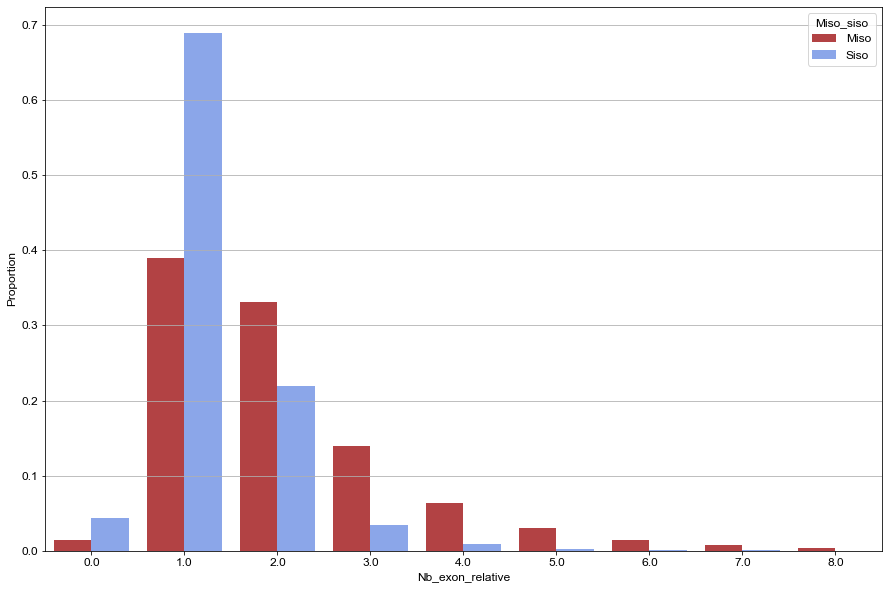

In [1431]:
f, ax = plt.subplots(figsize=(15,10))
utr_exon_distri = test_concat_cds_exons_relative_position.loc[(test_concat_cds_exons_relative_position['Type'] == 'CDS') & (test_concat_cds_exons_relative_position['Nb_exon'] == 1)].groupby('Miso_siso')['Nb_exon_relative'].value_counts().sort_index() / test_concat_cds_exons_relative_position.loc[(test_concat_cds_exons_relative_position['Type'] == 'CDS') & (test_concat_cds_exons_relative_position['Nb_exon'] == 1)].groupby('Miso_siso')['Nb_exon_relative'].count()
utr_exon_distri = utr_exon_distri.rename('Proportion').reset_index()
utr_exon_distri = utr_exon_distri.loc[utr_exon_distri['Nb_exon_relative'] <=8]
sns.barplot(data=utr_exon_distri, x='Nb_exon_relative', y='Proportion', hue='Miso_siso', palette=palette)
plt.grid(axis='y')
utr_exon_distri

In [1205]:
utrs = test_concat_cds_exons.dropna(subset=['UTR_bool']).reset_index(drop=True)
utrs[['UTR_Start', 'UTR_End']] = utrs.UTR_ranges.str.split('-', expand=True)
utrs[['UTR_Start', 'UTR_End']] = utrs[['UTR_Start', 'UTR_End']].astype(int)
utrs['UTR_Length'] = utrs['UTR_End'] - utrs['UTR_Start']
utrs

,NC,RefSeq_validation,Type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,RNA_name,Miso_siso,ranges,UTR_ranges,UTR_bool,Nb_exon,UTR_Start,UTR_End,UTR_Length
0,NC_000019.10,BestRefSeq,exon,58353404,58353492,.,-,.,ID=exon-NM_130786.4-1;Parent=rna-NM_130786.4;D...,89,A1BG,NaN,NM_130786.4,Siso,58353404-58353492,58353438-58353492,5_prime,1.00,58353438,58353492,54
1,NC_000019.10,BestRefSeq,exon,58345183,58347029,.,-,.,ID=exon-NM_130786.4-8;Parent=rna-NM_130786.4;D...,1847,A1BG,NaN,NM_130786.4,Siso,58345183-58347029,58345183-58347021,3_prime,8.00,58345183,58347021,1838
2,NC_000010.11,BestRefSeq,exon,50885581,50885627,.,-,.,ID=exon-NM_001198818.2-1;Parent=rna-NM_0011988...,47,A1CF,NaN,NM_001198818.2,Miso,50885581-50885627,50885581-50885627,5_prime,1.00,50885581,50885627,46
3,NC_000010.11,BestRefSeq,exon,50864033,50864080,.,-,.,ID=exon-NM_001198818.2-2;Parent=rna-NM_0011988...,48,A1CF,NaN,NM_001198818.2,Miso,50864033-50864080,50864033-50864080,5_prime,2.00,50864033,50864080,47
4,NC_000010.11,BestRefSeq,exon,50862889,50862981,.,-,.,ID=exon-NM_001198818.2-3;Parent=rna-NM_0011988...,93,A1CF,NaN,NM_001198818.2,Miso,50862889-50862981,50862889-50862981,5_prime,3.00,50862889,50862981,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187462,NC_000001.11,BestRefSeq,exon,77641522,77641655,.,-,.,ID=exon-NM_015534.6-2;Parent=rna-NM_015534.6;D...,134,ZZZ3,NaN,NM_015534.6,Miso,77641522-77641655,77641522-77641655,5_prime,2.00,77641522,77641655,133
187463,NC_000001.11,BestRefSeq,exon,77641384,77641446,.,-,.,ID=exon-NM_015534.6-3;Parent=rna-NM_015534.6;D...,63,ZZZ3,NaN,NM_015534.6,Miso,77641384-77641446,77641384-77641446,5_prime,3.00,77641384,77641446,62
187464,NC_000001.11,BestRefSeq,exon,77639449,77639602,.,-,.,ID=exon-NM_015534.6-4;Parent=rna-NM_015534.6;D...,154,ZZZ3,NaN,NM_015534.6,Miso,77639449-77639602,77639449-77639602,5_prime,4.00,77639449,77639602,153
187465,NC_000001.11,BestRefSeq,exon,77631850,77633405,.,-,.,ID=exon-NM_015534.6-5;Parent=rna-NM_015534.6;D...,1556,ZZZ3,NaN,NM_015534.6,Miso,77631850-77633405,77633355-77633405,5_prime,5.00,77633355,77633405,50


In [1242]:
utrs.loc[utrs['UTR_bool'] == '5_prime'].groupby(['Miso_siso','Gene', 'RNA_name'])['UTR_Length'].sum().reset_index().groupby('Miso_siso')['UTR_Length'].describe()

,count,mean,std,min,25%,50%,75%,max
Miso_siso,,,,,,,,
Miso,"53,594.00",291.57,282.67,1.00,104.00,209.00,383.00,"4,703.00"
Siso,"7,569.00",187.85,225.20,1.00,59.00,116.00,238.00,"4,215.00"


In [1420]:
utrs

,NC,RefSeq_validation,Type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,RNA_name,Miso_siso,ranges,UTR_ranges,UTR_bool,Nb_exon,UTR_Start,UTR_End,UTR_Length
0,NC_000019.10,BestRefSeq,exon,58353404,58353492,.,-,.,ID=exon-NM_130786.4-1;Parent=rna-NM_130786.4;D...,89,A1BG,NaN,NM_130786.4,Siso,58353404-58353492,58353438-58353492,5_prime,1.00,58353438,58353492,54
1,NC_000019.10,BestRefSeq,exon,58345183,58347029,.,-,.,ID=exon-NM_130786.4-8;Parent=rna-NM_130786.4;D...,1847,A1BG,NaN,NM_130786.4,Siso,58345183-58347029,58345183-58347021,3_prime,8.00,58345183,58347021,1838
2,NC_000010.11,BestRefSeq,exon,50885581,50885627,.,-,.,ID=exon-NM_001198818.2-1;Parent=rna-NM_0011988...,47,A1CF,NaN,NM_001198818.2,Miso,50885581-50885627,50885581-50885627,5_prime,1.00,50885581,50885627,46
3,NC_000010.11,BestRefSeq,exon,50864033,50864080,.,-,.,ID=exon-NM_001198818.2-2;Parent=rna-NM_0011988...,48,A1CF,NaN,NM_001198818.2,Miso,50864033-50864080,50864033-50864080,5_prime,2.00,50864033,50864080,47
4,NC_000010.11,BestRefSeq,exon,50862889,50862981,.,-,.,ID=exon-NM_001198818.2-3;Parent=rna-NM_0011988...,93,A1CF,NaN,NM_001198818.2,Miso,50862889-50862981,50862889-50862981,5_prime,3.00,50862889,50862981,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187462,NC_000001.11,BestRefSeq,exon,77641522,77641655,.,-,.,ID=exon-NM_015534.6-2;Parent=rna-NM_015534.6;D...,134,ZZZ3,NaN,NM_015534.6,Miso,77641522-77641655,77641522-77641655,5_prime,2.00,77641522,77641655,133
187463,NC_000001.11,BestRefSeq,exon,77641384,77641446,.,-,.,ID=exon-NM_015534.6-3;Parent=rna-NM_015534.6;D...,63,ZZZ3,NaN,NM_015534.6,Miso,77641384-77641446,77641384-77641446,5_prime,3.00,77641384,77641446,62
187464,NC_000001.11,BestRefSeq,exon,77639449,77639602,.,-,.,ID=exon-NM_015534.6-4;Parent=rna-NM_015534.6;D...,154,ZZZ3,NaN,NM_015534.6,Miso,77639449-77639602,77639449-77639602,5_prime,4.00,77639449,77639602,153
187465,NC_000001.11,BestRefSeq,exon,77631850,77633405,.,-,.,ID=exon-NM_015534.6-5;Parent=rna-NM_015534.6;D...,1556,ZZZ3,NaN,NM_015534.6,Miso,77631850-77633405,77633355-77633405,5_prime,5.00,77633355,77633405,50


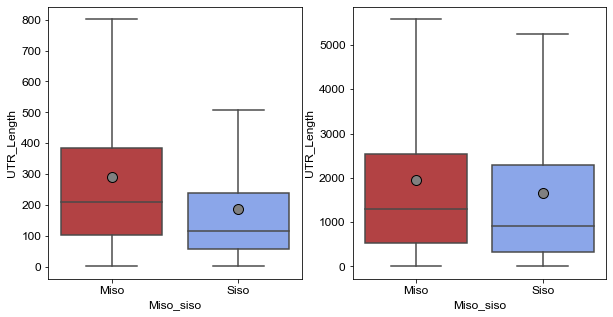

In [1425]:
f, ax = plt.subplots(figsize=(10,5), ncols=2)
five_prime_length_total = utrs.loc[utrs['UTR_bool'] == '5_prime'].groupby(['Miso_siso','Gene', 'RNA_name'])['UTR_Length'].sum().reset_index()
three_prime_length_total = utrs.loc[utrs['UTR_bool'] == '3_prime'].groupby(['Miso_siso','Gene', 'RNA_name'])['UTR_Length'].sum().reset_index()

sns.boxplot(data=five_prime_length_total, x='Miso_siso', y='UTR_Length', palette=palette, ax=ax[0], showfliers=False, showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10})
sns.boxplot(data=three_prime_length_total, x='Miso_siso', y='UTR_Length', palette=palette, ax=ax[1], showfliers=False, showmeans=True, meanline=False, meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10})

In [1243]:
utrs.loc[utrs['UTR_bool'] == '3_prime'].groupby(['Miso_siso','Gene', 'RNA_name'])['UTR_Length'].sum().reset_index().groupby('Miso_siso')['UTR_Length'].describe()

,count,mean,std,min,25%,50%,75%,max
Miso_siso,,,,,,,,
Miso,"51,873.00","1,953.45","2,225.21",1.00,528.00,"1,287.00","2,548.00","35,525.00"
Siso,"6,247.00","1,651.71","2,011.60",1.00,327.00,920.00,"2,296.50","25,445.00"


In [1212]:
utrs.loc[utrs['UTR_bool'] == '5_prime'].drop_duplicates(subset=['Gene', 'UTR_Start', 'UTR_End']).groupby(['Miso_siso', 'UTR_bool', 'Nb_exon'])['UTR_Length'].describe()

count   mean    std    min    25%    50%  \
Miso_siso UTR_bool Nb_exon                                                
Miso      5_prime  1.00    23,677.00 191.34 198.48   1.00  72.00 132.00   
                   2.00    12,495.00 103.43 133.89   1.00  35.00  79.00   
                   3.00     5,228.00 103.09 134.03   1.00  40.00  80.00   
                   4.00     2,404.00 103.29 122.96   1.00  43.00  83.00   
                   5.00     1,245.00 102.61 102.08   1.00  49.00  83.00   
                   6.00       716.00 100.10  82.76   1.00  51.00  85.00   
                   7.00       435.00 100.83  91.89   1.00  47.50  86.00   
                   8.00       251.00 114.62 150.48   4.00  53.00  90.00   
                   9.00       174.00 101.83  69.38   2.00  54.50  87.50   
                   10.00      100.00 114.10 111.40  11.00  59.75  94.00   
                   11.00       67.00 133.18 160.23   8.00  56.00 108.00   
                   12.00       43.00 180.05 250.65   3.00  47.00 118.00   
                   13.00       29.00 137.14 191.98   8.00  55.00 107.00   
                   14.00       23.00  98.83  78.81   3.00  50.00  80.00   
                   15.00       15.00 103.00  71.71  24.00  48.50  65.00   
                   16.00       10.00  89.80  54.42  20.00  37.50  95.00   
                   17.00        7.00  80.57  46.20   5.00  59.50  86.00   
                   18.00        6.00 153.83  66.53  84.00 101.00 152.50   
                   19.00        5.00 347.60 650.25   4.00  46.00  80.00   
                   20.00        3.00  88.67  23.50  65.00  77.00  89.00   
                   21.00        2.00 128.50  12.02 120.00 124.25 128.50   
                   22.00        2.00  84.00  53.74  46.00  65.00  84.00   
                   23.00        2.00 131.00  66.47  84.00 107.50 131.00   
                   24.00        1.00  18.00    nan  18.00  18.00  18.00   
Siso      5_prime  1.00     7,569.00 156.35 178.15   1.00  52.00  98.00   
                   2.00     2,114.00  82.90 164.73   1.00  17.00  42.00   
                   3.00       379.00  95.15 137.65   2.00  23.00  58.00   
                   4.00       106.00 169.79 379.85   1.00  28.50  78.00   
                   5.00        37.00 145.00 183.50   5.00  55.00  87.00   
                   6.00        19.00  79.53  56.58   3.00  34.50  76.00   
                   7.00        10.00  95.80  69.58  31.00  38.25  79.50   
                   8.00         5.00 159.40  97.25  50.00  93.00 163.00   
                   9.00         3.00  94.00  32.92  74.00  75.00  76.00   
                   10.00        2.00  57.00  74.95   4.00  30.50  57.00   
                   11.00        1.00  72.00    nan  72.00  72.00  72.00   

                              75%      max  
Miso_siso UTR_bool Nb_exon                  
Miso      5_prime  1.00    239.00 3,473.00  
                   2.00    128.00 4,400.00  
                   3.00    125.00 2,359.00  
                   4.00    128.00 2,236.00  
                   5.00    129.00 1,570.00  
                   6.00    128.00   808.00  
                   7.00    125.00   760.00  
                   8.00    137.50 2,079.00  
                   9.00    137.50   416.00  
                   10.00   131.25   923.00  
                   11.00   156.50 1,203.00  
                   12.00   159.00 1,326.00  
                   13.00   144.00 1,077.00  
                   14.00   129.00   343.00  
                   15.00   158.50   254.00  
                   16.00   130.00   167.00  
                   17.00   109.00   136.00  
                   18.00   179.25   262.00  
                   19.00    99.00 1,509.00  
                   20.00   100.50   112.00  
                   21.00   132.75   137.00  
                   22.00   103.00   122.00  
                   23.00   154.50   178.00  
                   24.00    18.00    18.00  
Siso      5_prime  1.00    196.00 2,539.00  
                   2.00     95.00 4,140.

In [639]:


def getOverlap(a, b):
    return max(0, min(a[1], b[1]) - max(a[0], b[0]))

def largest_interval(a,b):
    return [min([a[0], b[0]]), max([a[1], b[1]])]

def recursive_fct(overlap, ranges, c=0):
    c = c
#     print(c, overlap)
#     while overlap:
    empty_dict = dict()
    for j, (k,v) in enumerate(overlap.items()):
        v = [int(x) for x in v.split('-')]
        empty_dict[k] = [0,0]
        for i, e in enumerate(ranges):
            e = [int(x) for x in e.split('-')]
#             print(j,i,v,e, getOverlap(v,e), largest_interval(v,e), empty_dict[k])
            if getOverlap(v,e) > 0:
#                 print(j,i,v,e, getOverlap(v,e), largest_interval(v,e), empty_dict[k])
                li = largest_interval(v,e)
#                 print(li[1] - li[0], empty_dict[k][1] - empty_dict[k][0])
                if li[1] - li[0] > empty_dict[k][1] - empty_dict[k][0]: 
                    empty_dict[k] = largest_interval(v,e)
#         print('\n')
#     print(empty_dict)

    empty_dict = {k:"-".join([str(x) for x in v]) for k,v in empty_dict.items()}
    if empty_dict != overlap:
#         print(empty_dict)
        return recursive_fct(empty_dict, ranges, c+1)
    else:
        return empty_dict
#     overlap = empty_dict
#         recursive_fct(overlap, ranges)

def max_overlap(df):
    ranges = df.ranges.values.tolist()
    ranges_dict = {e:e for e in ranges}
#     print(ranges_dict)
#     print('\n TEST')
    d = recursive_fct(ranges_dict, ranges, 0)
    df['New_ranges'] = df['ranges'].map(d)
    return df

def get_introns(df):
    df = pd.DataFrame(df)
    l = list()
    exons = df['ranges'].values[0]
    for j, e in enumerate(exons):
        if j == 0:
            l.append(int(e.split("-")[1]) + 1)
        elif j > 0 and j < len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
            l.append(int(e.split("-")[1]) + 1)
        elif j == len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
    l = ["{}-{}".format(e, l[j + 1]) for j, e in enumerate(l) if j < len(l) - 1 if j % 2 == 0]
    df['Introns'] = [l]
    return df

def order_exon_by_strand_and_seq(df, col="Start"):
    if df.Strand.unique()[0] == "-":
        df = df.sort_values(by=col, ascending=False)
    elif df.Strand.unique()[0] == "+":
        df = df.sort_values(by=col, ascending=True)
    df["Exon_nb"] = list(range(1, df.shape[0] + 1))
    return df

# test_df['Gene'] = 'AAA'
# print(test_df)
# test_df.groupby('Gene').apply(max_overlap)
# test_df.groupby(['Gene', 'mRNA'])['ranges'].apply(list).reset_index().groupby(['Gene', 'mRNA']).apply(get_introns)
test_df['Strand'] = "-"
test_df.groupby(['Gene', 'mRNA']).apply(order_exon_by_strand_and_seq)

Start  End ID Gene mRNA ranges Strand  Exon_nb
Gene mRNA                                                  
AAA  1    6     18   20  D  AAA    1  18-20      -        1
          2     10   13  A  AAA    1  10-13      -        2
          1      6    7  A  AAA    1    6-7      -        3
          0      1    2  A  AAA    1    1-2      -        4
     2    7     10   15  D  AAA    2  10-15      -        1
          3      2    6  B  AAA    2    2-6      -        2
     3    4      2    4  D  AAA    3    2-4      -        1
     4    5      3    4  D  AAA    4    3-4      -        1
BBB  1    9     10   15  D  BBB    1  10-15      -        1
          8      3    4  D  BBB    1    3-4      -        2

In [654]:
refseq_exons_utr.loc[45]["Attributes"]

'ID=exon-NM_001005484.2-1;Parent=rna-NM_001005484.2;Dbxref=Ensembl:ENST00000641515.2,GeneID:79501,Genbank:NM_001005484.2,HGNC:HGNC:14825;gbkey=mRNA;gene=OR4F5;product=olfactory receptor family 4 subfamily F member 5;tag=MANE Select;transcript_id=NM_001005484.2'

In [ ]:
refseq_cds = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_cds"])
refseq_cds['Length'] = refseq_cds['End'] - refseq_cds['Start']
refseq_cds = refseq_cds.loc[refseq_cds['Length'] > 0] 
refseq_cds['Gene'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_cds['NP'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('ID=cds-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] = refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] + '-2'
refseq_cds = pd.merge(refseq_cds, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_cds[['Start', 'End']] = refseq_cds[['Start', 'End']].astype(int)
refseq_cds['ranges'] = refseq_cds['Start'].astype(str) + '-' + refseq_cds['End'].astype(str)


# refseq_cds_dd_tmp = refseq_cds.drop_duplicates(subset=['Gene','NP','ranges'])
refseq_cds_dd_tmp = refseq_cds.groupby(['Gene', 'NP']).progress_apply(order_exon_by_strand_and_seq)
refseq_cds_dd_tmp

In [ ]:
refseq_cds_dd_ordinal = refseq_cds_dd_tmp.reset_index(drop=True)
refseq_cds_dd_ordinal.loc[refseq_cds_dd_ordinal['Exon_nb'] <= 10].groupby(['Miso_siso', 'Exon_nb'])['Length'].describe()

In [397]:
refseq_cds = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_cds"])
refseq_cds['Length'] = refseq_cds['End'] - refseq_cds['Start']
refseq_cds = refseq_cds.loc[refseq_cds['Length'] > 0] 
refseq_cds['Gene'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_cds['NP'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('ID=cds-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] = refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] + '-2'
refseq_cds = pd.merge(refseq_cds, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_cds[['Start', 'End']] = refseq_cds[['Start', 'End']].astype(int)
refseq_cds['ranges'] = refseq_cds['Start'].astype(str) + '-' + refseq_cds['End'].astype(str)


refseq_cds_dd_tmp = refseq_cds.drop_duplicates(subset=['Gene','ranges'])
refseq_cds_dd_tmp = refseq_cds_dd_tmp.groupby('Gene').progress_apply(max_overlap)
refseq_cds_dd_tmp

100%|██████████| 19285/19285 [01:05<00:00, 293.13it/s]


,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,Miso_siso,ranges,New_ranges
0,NC_000001.11,BestRefSeq,CDS,65565,65573,.,+,0,ID=cds-NP_001005484.2;Parent=rna-NM_001005484....,8,OR4F5,NP_001005484.2,Siso,65565-65573,65565-65573
1,NC_000001.11,BestRefSeq,CDS,69037,70008,.,+,0,ID=cds-NP_001005484.2;Parent=rna-NM_001005484....,971,OR4F5,NP_001005484.2,Siso,69037-70008,69037-70008
2,NC_000001.11,BestRefSeq,CDS,450740,451678,.,-,0,ID=cds-NP_001005221.2;Parent=rna-NM_001005221....,938,OR4F29,NP_001005221.2,Siso,450740-451678,450740-451678
3,NC_000001.11,BestRefSeq,CDS,685716,686654,.,-,0,ID=cds-NP_001005277.1;Parent=rna-NM_001005277....,938,OR4F16,NP_001005277.1,Siso,685716-686654,685716-686654
4,NC_000001.11,BestRefSeq,CDS,924432,924948,.,+,0,ID=cds-NP_001372569.1;Parent=rna-NM_001385640....,516,SAMD11,NP_001372569.1,Miso,924432-924948,924432-924948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673224,NC_000024.10,BestRefSeq,CDS,57189426,57189539,.,+,2,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,113,IL9R-2,NP_002177.2-2,Miso,57189426-57189539,57189402-57189539
673226,NC_000024.10,BestRefSeq,CDS,57190197,57190375,.,+,1,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,178,IL9R-2,NP_002177.2-2,Miso,57190197-57190375,57190197-57190375
673227,NC_000024.10,BestRefSeq,CDS,57190940,57191085,.,+,2,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,145,IL9R-2,NP_002177.2-2,Miso,57190940-57191085,57190940-57191085
673230,NC_000024.10,BestRefSeq,CDS,57194043,57194127,.,+,1,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,84,IL9R-2,NP_002177.2-2,Miso,57194043-57194127,57194043-57194127


In [403]:
refseq_cds_dd_tmp
refseq_cds_dd_tmp[['New_Start', 'New_End']] = refseq_cds_dd_tmp.New_ranges.str.split('-', expand=True)
refseq_cds_dd_tmp[['New_Start', 'New_End']] = refseq_cds_dd_tmp[['New_Start', 'New_End']].astype(int)
refseq_cds_dd_tmp['New_Length'] = refseq_cds_dd_tmp['New_End'] - refseq_cds_dd_tmp['New_Start']
print(refseq_cds_dd_tmp.loc[refseq_cds_dd_tmp.duplicated(keep=False, subset=['Gene', 'New_ranges']) == True].shape)
refseq_cds_dd_tmp.loc[refseq_cds_dd_tmp.duplicated(subset=['Gene', 'New_ranges']) == True].groupby('Miso_siso')['New_Length'].describe().T

(27256, 18)


Miso_siso,Miso
count,"14,428.00"
mean,270.12
std,405.12
min,4.00
25%,109.00
50%,157.00
75%,240.00
max,"7,538.00"


In [400]:
refseq_cds_dd_tmp.loc[refseq_cds_dd_tmp['New_ranges'].duplicated(keep=False) == True].shape

(29308, 18)

In [381]:
refseq_cds_dd_tmp[['Gene', 'New_ranges']].drop_duplicates().shape

(200417, 2)

In [380]:
refseq_cds_dd_tmp[['Gene', 'ranges']].drop_duplicates().shape

(214910, 2)

In [154]:
def ordinal_position_intron(df):
    df["Intron_nb"] = list(range(1, df.shape[0] + 1))
    return df

refseq_introns_explode = refseq_introns_explode.groupby('Gene').progress_apply(ordinal_position_intron)

100%|██████████| 17261/17261 [00:13<00:00, 1264.68it/s]


In [143]:
refseq_cds_dd_ordinal = refseq_cds_dd.reset_index(drop=True)
refseq_cds_dd_ordinal.loc[refseq_cds_dd_ordinal['Exon_nb'] <= 10].groupby(['Miso_siso', 'Exon_nb'])['New_Length'].describe()

count   mean    std  min   25%    50%    75%       max
Miso_siso Exon_nb                                                           
Miso      1       11,368.00 215.39 394.74 1.00 51.00 100.00 197.00  6,045.00
          2       10,955.00 173.23 276.68 1.00 77.00 119.00 174.00 12,707.00
          3       10,618.00 169.12 297.19 1.00 83.25 121.00 170.00 17,330.00
          4       10,125.00 172.78 262.30 1.00 84.00 121.00 169.00  6,876.00
          5        9,273.00 161.69 239.68 1.00 85.00 121.00 166.00  6,501.00
          6        8,465.00 149.26 180.98 1.00 83.00 117.00 161.00  3,177.00
          7        7,619.00 151.99 287.96 1.00 84.00 120.00 162.00 16,736.00
          8        6,897.00 149.77 241.30 2.00 83.00 118.00 159.00  7,151.00
          9        6,219.00 149.82 261.06 2.00 84.00 119.00 160.00 11,554.00
          10       5,605.00 144.64 186.71 2.00 84.00 119.00 161.00  8,246.00
Siso      1        7,917.00 383.26 592.90 1.00 74.00 159.00 475.00 15,266.00
          2        6,306.00 221.86 437.34 3.00 93.25 132.00 200.00 14,888.00
          3        5,553.00 181.17 420.10 3.00 89.00 125.00 174.00 21,692.00
          4        4,879.00 194.32 455.14 2.00 88.00 125.00 170.00 20,937.00
          5        4,191.00 156.14 230.14 2.00 89.00 123.00 164.00  6,653.00
          6        3,687.00 152.59 211.63 5.00 88.50 122.00 165.00  7,312.00
          7        3,217.00 147.86 170.44 3.00 85.00 122.00 165.00  3,932.00
          8        2,823.00 153.11 215.37 4.00 87.00 120.00 163.00  4,655.00
          9        2,507.00 151.38 202.55 5.00 90.50 123.00 166.00  5,414.00
          10       2,170.00 153.36 266.51 2.00 89.00 122.00 162.00  6,700.00

In [158]:
refseq_introns_explode.loc[refseq_introns_explode['Intron_nb'] <= 10].groupby(['Miso_siso', 'Intron_nb'])['Introns_lengths'].describe()

count     mean       std   min    25%      50%  \
Miso_siso Intron_nb                                                      
Miso      1         10,955.00 9,477.43 28,028.44  4.00 639.00 2,059.00   
          2         10,618.00 6,816.44 22,990.32  3.00 537.00 1,670.50   
          3         10,125.00 5,937.07 17,664.07  5.00 540.00 1,679.00   
          4          9,273.00 5,599.41 18,629.01  8.00 486.00 1,536.00   
          5          8,465.00 5,432.21 16,349.80  3.00 505.00 1,573.00   
          6          7,619.00 5,293.93 15,834.77 13.00 508.50 1,550.00   
          7          6,897.00 5,176.85 17,007.79  5.00 496.00 1,554.00   
          8          6,219.00 5,310.10 17,506.97  6.00 503.00 1,545.00   
          9          5,605.00 5,121.15 17,290.86  4.00 519.00 1,591.00   
          10         5,042.00 5,361.94 20,344.16 10.00 505.25 1,617.50   
Siso      1          6,306.00 8,390.96 29,300.65 37.00 615.00 1,806.50   
          2          5,553.00 5,299.96 18,976.82 65.00 447.00 1,464.00   
          3          4,879.00 4,500.02 13,185.55 65.00 474.00 1,425.00   
          4          4,191.00 4,440.09 16,420.31 67.00 417.00 1,261.00   
          5          3,687.00 4,126.81 12,453.00 68.00 421.50 1,273.00   
          6          3,217.00 4,415.30 13,965.47 68.00 410.00 1,345.00   
          7          2,823.00 3,899.48 16,458.14 67.00 428.00 1,308.00   
          8          2,507.00 3,739.58 10,300.62 58.00 424.50 1,280.00   
          9          2,170.00 3,998.92 13,473.01 71.00 417.00 1,352.50   
          10         1,910.00 3,852.59 11,659.21 65.00 384.00 1,186.00   

                         75%        max  
Miso_siso Intron_nb                      
Miso      1         6,380.50 769,395.00  
          2         4,655.75 907,997.00  
          3         4,480.00 407,750.00  
          4         4,042.00 501,759.00  
          5         4,088.00 544,980.00  
          6         4,012.00 404,679.00  
          7         3,991.00 682,658.00  
          8         3,953.50 589,171.00  
          9         4,068.00 778,855.00  
          10        4,147.00 863,862.00  
Siso      1         5,235.50 740,920.00  
          2         3,842.00 654,926.00  
          3         3,652.50 313,977.00  
          4         3,230.00 460,671.00  
          5         3,284.50 248,959.00  
          6         3,439.00 347,007.00  
          7         3,284.50 721,292.00  
          8         3,214.50 202,562.00  
          9         3,301.75 357,890.00  
          10        2,974.75 272,883.00

In [131]:
refseq_exons = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_exons"])
refseq_exons['Length'] = refseq_exons['End'] - refseq_exons['Start']
refseq_exons = refseq_exons.loc[refseq_exons['Length'] > 0] 
refseq_exons['Gene'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons['NM'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('ID=exon-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] = refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] + '-2'
refseq_exons = pd.merge(refseq_exons, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_exons[['Start', 'End']] = refseq_exons[['Start', 'End']].astype(int)
refseq_exons['ranges'] = refseq_exons['Start'].astype(str) + '-' + refseq_exons['End'].astype(str)
refseq_exons

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NM,Miso_siso,ranges
0,NC_000001.11,BestRefSeq,exon,65419,65433,.,+,.,ID=exon-NM_001005484.2-1;Parent=rna-NM_0010054...,14,OR4F5,NM_001005484.2-1,Siso,65419-65433
1,NC_000001.11,BestRefSeq,exon,69037,71585,.,+,.,ID=exon-NM_001005484.2-3;Parent=rna-NM_0010054...,2548,OR4F5,NM_001005484.2-3,Siso,69037-71585
2,NC_000001.11,BestRefSeq,exon,450740,451678,.,-,.,ID=exon-NM_001005221.2-1;Parent=rna-NM_0010052...,938,OR4F29,NM_001005221.2-1,Siso,450740-451678
3,NC_000001.11,BestRefSeq,exon,685716,686654,.,-,.,ID=exon-NM_001005277.1-1;Parent=rna-NM_0010052...,938,OR4F16,NM_001005277.1-1,Siso,685716-686654
4,NC_000001.11,BestRefSeq,exon,923923,924948,.,+,.,ID=exon-NM_001385640.1-1;Parent=rna-NM_0013856...,1025,SAMD11,NM_001385640.1-1,Miso,923923-924948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621883,NC_000024.10,BestRefSeq,exon,25037992,25038116,.,-,.,ID=exon-NM_001002761.1-7;Parent=rna-NM_0010027...,124,BPY2C,NM_001002761.1-7,Siso,25037992-25038116
621884,NC_000024.10,BestRefSeq,exon,25031317,25031441,.,-,.,ID=exon-NM_001002761.1-8;Parent=rna-NM_0010027...,124,BPY2C,NM_001002761.1-8,Siso,25031317-25031441
621885,NC_000024.10,BestRefSeq,exon,25030901,25031222,.,-,.,ID=exon-NM_001002761.1-9;Parent=rna-NM_0010027...,321,BPY2C,NM_001002761.1-9,Siso,25030901-25031222
621886,NC_000024.10,BestRefSeq,exon,25622117,25624034,.,+,.,ID=exon-NM_004680.3-1;Parent=rna-NM_004680.3;D...,1917,CDY1,NM_004680.3-1,Miso,25622117-25624034


In [364]:
refseq_exons_dd.reset_index(drop=True)

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NM,Miso_siso,ranges,New_ranges,New_Start,New_End,New_Length,Exon_nb
0,NC_000019.10,BestRefSeq,exon,58353404,58353492,.,-,.,ID=exon-NM_130786.4-1;Parent=rna-NM_130786.4;D...,88,A1BG,NM_130786.4-1,Siso,58353404-58353492,58353404-58353492,58353404,58353492,88,1
1,NC_000019.10,BestRefSeq,exon,58352928,58353197,.,-,.,ID=exon-NM_130786.4-3;Parent=rna-NM_130786.4;D...,269,A1BG,NM_130786.4-3,Siso,58352928-58353197,58352928-58353197,58352928,58353197,269,2
2,NC_000019.10,BestRefSeq,exon,58352283,58352555,.,-,.,ID=exon-NM_130786.4-4;Parent=rna-NM_130786.4;D...,272,A1BG,NM_130786.4-4,Siso,58352283-58352555,58352283-58352555,58352283,58352555,272,3
3,NC_000019.10,BestRefSeq,exon,58351391,58351687,.,-,.,ID=exon-NM_130786.4-5;Parent=rna-NM_130786.4;D...,296,A1BG,NM_130786.4-5,Siso,58351391-58351687,58351391-58351687,58351391,58351687,296,4
4,NC_000019.10,BestRefSeq,exon,58350370,58350651,.,-,.,ID=exon-NM_130786.4-6;Parent=rna-NM_130786.4;D...,281,A1BG,NM_130786.4-6,Siso,58350370-58350651,58350370-58350651,58350370,58350651,281,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186028,NC_000001.11,BestRefSeq,exon,77578774,77578869,.,-,.,ID=exon-NM_001376151.1-9;Parent=rna-NM_0013761...,95,ZZZ3,NM_001376151.1-9,Miso,77578774-77578869,77578774-77578869,77578774,77578869,95,11
186029,NC_000001.11,BestRefSeq,exon,77576068,77576220,.,-,.,ID=exon-NM_001376151.1-10;Parent=rna-NM_001376...,152,ZZZ3,NM_001376151.1-10,Miso,77576068-77576220,77576068-77576220,77576068,77576220,152,12
186030,NC_000001.11,BestRefSeq,exon,77568332,77568466,.,-,.,ID=exon-NM_001376151.1-11;Parent=rna-NM_001376...,134,ZZZ3,NM_001376151.1-11,Miso,77568332-77568466,77568332-77568466,77568332,77568466,134,13
186031,NC_000001.11,BestRefSeq,exon,77566081,77566181,.,-,.,ID=exon-NM_001376151.1-12;Parent=rna-NM_001376...,100,ZZZ3,NM_001376151.1-12,Miso,77566081-77566181,77566081-77566181,77566081,77566181,100,14


In [132]:
refseq_exons = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_exons"])
refseq_exons['Length'] = refseq_exons['End'] - refseq_exons['Start']
refseq_exons = refseq_exons.loc[refseq_exons['Length'] > 0] 
refseq_exons['Gene'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons['NM'] = refseq_exons['Attributes'].apply(lambda r: [e.replace('ID=exon-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] = refseq_exons.loc[refseq_exons['NM'].str.contains('-2'), 'Gene'] + '-2'
refseq_exons = pd.merge(refseq_exons, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_exons[['Start', 'End']] = refseq_exons[['Start', 'End']].astype(int)
refseq_exons['ranges'] = refseq_exons['Start'].astype(str) + '-' + refseq_exons['End'].astype(str)


refseq_exons_dd = refseq_exons.drop_duplicates(subset=['Gene','ranges'])
refseq_exons_dd = refseq_exons_dd.groupby('Gene').progress_apply(max_overlap)
refseq_exons_dd = refseq_exons_dd.drop_duplicates(subset=['Gene', 'New_ranges'])

refseq_exons_dd[['New_Start', 'New_End']] = refseq_exons_dd.New_ranges.str.split('-', expand=True)
refseq_exons_dd[['New_Start', 'New_End']] = refseq_exons_dd[['New_Start', 'New_End']].astype(int)
refseq_exons_dd['New_Length'] = refseq_exons_dd['New_End'] - refseq_exons_dd['New_Start']
refseq_exons_dd = refseq_exons_dd.reset_index(drop=True)

def order_exon_by_strand_and_seq(df, col="ranges"):
    if df.Strand.unique()[0] == "-":
        df = df.sort_values(by=col, ascending=False)
    elif df.Strand.unique()[0] == "+":
        df = df.sort_values(by=col, ascending=True)
    df["Exon_nb"] = list(range(1, df.shape[0] + 1))
    return df


refseq_exons_dd = refseq_exons_dd.groupby("Gene").progress_apply(order_exon_by_strand_and_seq, col="New_Start")




def compute_introns_ranges_apply_fct(r, col='ranges'):
    # print(r)
    l = list()
    exons = r[col]
    # try:

    exons_start = list(sorted([int(e.split("-")[0]) for e in exons]))
    exons_end = list(sorted([int(e.split("-")[1]) for e in exons]))
    exons = ["{}-{}".format(s, e) for s, e in zip(exons_start, exons_end)]
    for j, e in enumerate(exons):
        if j == 0:
            l.append(int(e.split("-")[1]) + 1)
        elif j > 0 and j < len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
            l.append(int(e.split("-")[1]) + 1)
        elif j == len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
    l = ["{}-{}".format(e, l[j + 1]) for j, e in enumerate(l) if j < len(l) - 1 if j % 2 == 0]
    r["Introns_ranges"] = l
    r["Introns_lengths"] = [int(e.split("-")[1]) - int(e.split("-")[0]) + 1 for e in l]

    return r

refseq_introns_exons = refseq_exons_dd[['Gene', 'New_ranges']].reset_index(drop=True).groupby('Gene')['New_ranges'].apply(list).reset_index().progress_apply(lambda r: compute_introns_ranges_apply_fct(r, 'New_ranges'), axis=1)

refseq_introns_exons_explode = refseq_introns_exons.explode('Introns_lengths')
refseq_introns_exons_explode = pd.merge(refseq_introns_exons_explode, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene').dropna(subset=['Introns_lengths'])
refseq_introns_exons_explode



100%|██████████| 19285/19285 [00:38<00:00, 507.19it/s]


,Gene,New_ranges,Introns_ranges,Introns_lengths,Miso_siso
0,A1BG,"[58353404-58353492, 58352928-58353197, 5835228...","[58347030-58347352, 58347641-58350369, 5835065...",323,Siso
1,A1BG,"[58353404-58353492, 58352928-58353197, 5835228...","[58347030-58347352, 58347641-58350369, 5835065...",2729,Siso
2,A1BG,"[58353404-58353492, 58352928-58353197, 5835228...","[58347030-58347352, 58347641-58350369, 5835065...",739,Siso
3,A1BG,"[58353404-58353492, 58352928-58353197, 5835228...","[58347030-58347352, 58347641-58350369, 5835065...",595,Siso
4,A1BG,"[58353404-58353492, 58352928-58353197, 5835228...","[58347030-58347352, 58347641-58350369, 5835065...",372,Siso
...,...,...,...,...,...
168834,ZZZ3,"[77683262-77683398, 77682585-77682658, 7764138...","[77565785-77566080, 77566182-77568331, 7756846...",47194,Miso
168835,ZZZ3,"[77683262-77683398, 77682585-77682658, 7764138...","[77565785-77566080, 77566182-77568331, 7756846...",6043,Miso
168836,ZZZ3,"[77683262-77683398, 77682585-77682658, 7764138...","[77565785-77566080, 77566182-77568331, 7756846...",1781,Miso
168837,ZZZ3,"[77683262-77683398, 77682585-77682658, 7764138...","[77565785-77566080, 77566182-77568331, 7756846...",41138,Miso


In [355]:

def describe_dev(df):
    d = df.describe().T
    d['Diff%'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
#     print(d)
    d.loc['Sum'] = df.sum()
    
    return d

concat_exon_cds_intron_length = pd.concat(
    [
        describe_dev(refseq_exons_dd_ordinal.groupby(['Miso_siso'])['New_Length']),
        describe_dev(refseq_cds_dd_ordinal.groupby(['Miso_siso'])['New_Length']),
        describe_dev(refseq_introns_explode
                     .groupby(['Miso_siso'])['Introns_lengths']),
    ],
    axis=1
)
concat_exon_cds_intron_length.columns = pd.MultiIndex.from_product([['Exon', 'CDS', 'Intron'], ['Miso', 'Siso', "Diff%"]])
concat_exon_cds_intron_length
concat_exon_cds_intron_length = concat_exon_cds_intron_length.T


concat_exon_cds_intron_count = pd.concat(
    [
        describe_dev(refseq_exons_dd_ordinal.groupby(['Miso_siso', 'Gene'])['New_Length'].count().groupby('Miso_siso')),
        describe_dev(refseq_cds_dd_ordinal.groupby(['Miso_siso', 'Gene'])['New_Length'].count().groupby('Miso_siso')),
        describe_dev(refseq_introns_explode.groupby(['Miso_siso', 'Gene'])['Introns_lengths'].count().groupby('Miso_siso')),
    ],
    axis=1
)
concat_exon_cds_intron_count.columns = pd.MultiIndex.from_product([['Exon', 'CDS', 'Intron'], ['Miso', 'Siso', "Diff%"]])
concat_exon_cds_intron_count = concat_exon_cds_intron_count.T

concat_length_distri_exon_cds_intron = pd.concat(
    [
        concat_exon_cds_intron_length.T,
        concat_exon_cds_intron_count.T,
    ], axis=1
)
concat_length_distri_exon_cds_intron

concat_length_distri_exon_cds_intron.columns = pd.MultiIndex.from_product([['Length', 'Distribution'], ['Exon', 'CDS', 'Intron'], ['Miso', 'Siso', "Diff%"]])
concat_length_distri_exon_cds_intron.to_excel('/gstock/GeneIso/results/2_exon_cds_intron_length_distri.xlsx')
concat_gene_iso_level.to_excel('/gstock/GeneIso/results/GeneIso.xlsx', sheet_name='2_Exon_CDS_Intron_level')
concat_length_distri_exon_cds_intron
concat_length_distri_exon_cds_intron

Length                                                         \
               Exon                               CDS                        
               Miso          Siso Diff%          Miso          Siso  Diff%   
count    130,472.00     55,561.00 57.42    136,120.00     64,297.00  52.76   
mean         345.52        378.58 -9.57        160.90        193.35 -20.17   
std          904.75        949.49 -4.94        255.20        365.15 -43.08   
min            2.00          2.00  0.00          1.00          1.00   0.00   
25%           92.00         95.00 -3.26         82.00         89.00  -8.54   
50%          133.00        137.00 -3.01        120.00        127.00  -5.83   
75%          200.00        207.00 -3.50        167.00        177.00  -5.99   
max       35,595.00     27,302.00 23.30     17,330.00     21,692.00 -25.17   
Sum   45,080,113.00 21,034,117.00   nan 21,901,704.00 12,431,615.00    nan   

                                          Distribution                  \
              Intron                              Exon                   
                Miso           Siso Diff%         Miso      Siso Diff%   
count     124,752.00      56,380.00 54.81    11,368.00  7,917.00 30.36   
mean        5,881.73       4,587.53 22.00        11.48      7.02 38.85   
std        19,131.04      16,271.69 14.95         9.11      8.48  6.95   
min             3.00           3.00  0.00         1.00      1.00  0.00   
25%           527.00         437.00 17.08         6.00      2.00 66.67   
50%         1,602.00       1,309.00 18.29        10.00      4.00 60.00   
75%         4,220.00       3,408.00 19.24        16.00     10.00 37.50   
max       907,997.00     740,920.00 18.40       347.00    160.00 53.89   
Sum   733,757,413.00 258,645,186.00   nan   130,472.00 55,561.00   nan   

                                                             
             CDS                     Intron                  
            Miso      Siso Diff%       Miso      Siso Diff%  
count  11,368.00  7,917.00 30.36  10,955.00  6,306.00 42.44  
mean       11.97      8.12 32.17      11.39      8.94 21.49  
std        10.60     10.26  3.22      10.58     10.77 -1.77  
min         1.00      1.00  0.00       1.00      1.00  0.00  
25%         5.00      2.00 60.00       5.00      3.00 40.00  
50%         9.00      5.00 44.44       9.00      6.00 33.33  
75%        15.00     10.00 33.33      15.00     11.00 26.67  
max       363.00    171.00 52.89     362.00    170.00 53.04  
Sum   136,120.00 64,297.00   nan 124,752.00 56,380.00   nan

In [241]:
pd.options.display.max_columns = 30
concat_ordinal = pd.concat(
    [
        describe_dev(refseq_exons_dd_ordinal.loc[refseq_exons_dd_ordinal['Exon_nb'] <= 10].groupby(['Miso_siso', 'Exon_nb'])['New_Length']),
        describe_dev(refseq_cds_dd_ordinal.loc[refseq_cds_dd_ordinal['Exon_nb'] <= 10].groupby(['Miso_siso', 'Exon_nb'])['New_Length']),
        describe_dev(refseq_introns_explode.loc[refseq_introns_explode['Intron_nb'] <= 10].groupby(['Miso_siso', 'Intron_nb'])['Introns_lengths']),
    ],
    axis=0
).T
concat_ordinal.columns = pd.MultiIndex.from_product([['Exon', 'CDS', 'Intron'], ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Sum']])
concat_ordinal = concat_ordinal.T
concat_ordinal.to_excel('/gstock/GeneIso/results/3_exon_cds_intron_length_ordinal.xlsx')
concat_gene_iso_level.to_excel('/gstock/GeneIso/results/GeneIso.xlsx', sheet_name='3_Exon_CDS_Intron_Ordinal_level')
concat_ordinal


Miso_siso              Miso                                            \
Exon_nb                  1             2             3             4    
Exon   count      11,368.00     11,238.00     10,797.00     10,156.00   
       mean          282.34        274.98        310.85        328.78   
       std           406.65        570.01        747.83        869.71   
       min             7.00          2.00          2.00          2.00   
       25%           109.00         91.00         90.00         91.00   
       50%           182.00        137.00        131.00        128.00   
       75%           323.00        230.00        200.00        189.00   
       max        12,343.00     10,527.00     14,750.00     30,080.00   
       Sum     3,209,616.00  3,090,229.00  3,356,296.00  3,339,108.00   
CDS    count      11,368.00     10,955.00     10,618.00     10,125.00   
       mean          215.39        173.23        169.12        172.78   
       std           394.74        276.68        297.19        262.30   
       min             1.00          1.00          1.00          1.00   
       25%            51.00         77.00         83.25         84.00   
       50%           100.00        119.00        121.00        121.00   
       75%           197.00        174.00        170.00        169.00   
       max         6,045.00     12,707.00     17,330.00      6,876.00   
       Sum     2,448,581.00  1,897,702.00  1,795,694.00  1,749,370.00   
Intron count      10,955.00     10,618.00     10,125.00      9,273.00   
       mean        9,477.43      6,816.44      5,937.07      5,599.41   
       std        28,028.44     22,990.32     17,664.07     18,629.01   
       min             4.00          3.00          5.00          8.00   
       25%           639.00        537.00        540.00        486.00   
       50%         2,059.00      1,670.50      1,679.00      1,536.00   
       75%         6,380.50      4,655.75      4,480.00      4,042.00   
       max       769,395.00    907,997.00    407,750.00    501,759.00   
       Sum   103,825,260.00 72,377,001.00 60,112,831.00 51,923,292.00   

Miso_siso                                                             \
Exon_nb                 5             6             7             8    
Exon   count      9,405.00      8,540.00      7,749.00      7,032.00   
       mean         354.21        345.36        342.52        368.70   
       std          961.52        886.90        934.16        971.47   
       min            2.00          2.00          4.00          2.00   
       25%           90.00         91.00         90.00         90.00   
       50%          128.00        129.00        126.00        127.00   
       75%          189.00        186.00        182.00        182.00   
       max       23,263.00     18,172.00     17,546.00     13,737.00   
       Sum    3,331,304.00  2,949,384.00  2,654,220.00  2,592,668.00   
CDS    count      9,273.00      8,465.00      7,619.00      6,897.00   
       mean         161.69        149.26        151.99        149.77   
       std          239.68        180.98        287.96        241.30   
       min            1.00          1.00          1.00          2.00   
       25%           85.00         83.00         84.00         83.00   
       50%          121.00        117.00        120.00        118.00   
       75%          166.00        161.00        162.00        159.00   
       max        6,501.00      3,177.00     16,736.00      7,151.00   
       Sum    1,499,376.00  1,263,521.00  1,157,987.00  1,032,950.00   
Intron count      8,465.00      7,619.00      6,897.00      6,219.00   
       mean       5,432.21      5,293.93      5,176.85      5,310.10   
       std       16,349.80     15,834.77     17,007.79     17,506.97   
       min            3.00         13.00          5.00          6.00   
       25%          505.00        508.50        496.00        503.00   
       50%        1,573.00      1,550.00      1,554.00      1,545.00   
       75%

In [198]:

concat_exon_cds_intron_length = pd.concat(
    [
        refseq_exons_dd_ordinal.groupby(['Miso_siso'])['New_Length'].describe(),
        refseq_cds_dd_ordinal.groupby(['Miso_siso'])['New_Length'].describe(),
        refseq_introns_explode.groupby(['Miso_siso'])['Introns_lengths'].describe(),
    ],
    axis=1
)
concat_exon_cds_intron_length.columns = pd.MultiIndex.from_product([['Exon', 'CDS', 'Intron'], ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])

concat_exon_cds_intron_count = pd.concat(
    [
        refseq_exons_dd_ordinal.groupby(['Miso_siso', 'Gene'])['New_Length'].count().groupby('Miso_siso').describe(),
        refseq_cds_dd_ordinal.groupby(['Miso_siso', 'Gene'])['New_Length'].count().groupby('Miso_siso').describe(),
        refseq_introns_explode.groupby(['Miso_siso', 'Gene'])['Introns_lengths'].count().groupby('Miso_siso').describe(),
    ],
    axis=1
)
concat_exon_cds_intron_count.columns = pd.MultiIndex.from_product([['Exon', 'CDS', 'Intron'], ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']])

concat_length_distri_exon_cds_intron = pd.concat(
    [
        concat_exon_cds_intron_length.T,
        concat_exon_cds_intron_count.T,
    ], axis=1
)
concat_length_distri_exon_cds_intron.columns = pd.MultiIndex.from_product([['Length', 'Distribution'], ['Miso',  'Siso']])
concat_length_distri_exon_cds_intron

Length            Distribution         
                   Miso       Siso         Miso     Siso
Exon   count 130,472.00  55,561.00    11,368.00 7,917.00
       mean      345.52     378.58        11.48     7.02
       std       904.75     949.49         9.11     8.48
       min         2.00       2.00         1.00     1.00
       25%        92.00      95.00         6.00     2.00
       50%       133.00     137.00        10.00     4.00
       75%       200.00     207.00        16.00    10.00
       max    35,595.00  27,302.00       347.00   160.00
CDS    count 136,120.00  64,297.00    11,368.00 7,917.00
       mean      160.90     193.35        11.97     8.12
       std       255.20     365.15        10.60    10.26
       min         1.00       1.00         1.00     1.00
       25%        82.00      89.00         5.00     2.00
       50%       120.00     127.00         9.00     5.00
       75%       167.00     177.00        15.00    10.00
       max    17,330.00  21,692.00       363.00   171.00
Intron count 124,752.00  56,380.00    10,955.00 6,306.00
       mean    5,881.73   4,587.53        11.39     8.94
       std    19,131.04  16,271.69        10.58    10.77
       min         3.00       3.00         1.00     1.00
       25%       527.00     437.00         5.00     3.00
       50%     1,602.00   1,309.00         9.00     6.00
       75%     4,220.00   3,408.00        15.00    11.00
       max   907,997.00 740,920.00       362.00   170.00

In [119]:
def compute_introns_ranges_apply_fct(r, col='ranges'):
    # print(r)
    l = list()
    exons = r[col]
    # try:

    exons_start = list(sorted([int(e.split("-")[0]) for e in exons]))
    exons_end = list(sorted([int(e.split("-")[1]) for e in exons]))
    exons = ["{}-{}".format(s, e) for s, e in zip(exons_start, exons_end)]
    for j, e in enumerate(exons):
        if j == 0:
            l.append(int(e.split("-")[1]) + 1)
        elif j > 0 and j < len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
            l.append(int(e.split("-")[1]) + 1)
        elif j == len(exons) - 1:
            l.append(int(e.split("-")[0]) - 1)
    l = ["{}-{}".format(e, l[j + 1]) for j, e in enumerate(l) if j < len(l) - 1 if j % 2 == 0]
    r["Introns_ranges"] = l
    r["Introns_lengths"] = [int(e.split("-")[1]) - int(e.split("-")[0]) + 1 for e in l]

    return r

refseq_introns = refseq_cds_dd[['Gene', 'New_ranges']].reset_index(drop=True).groupby('Gene')['New_ranges'].apply(list).reset_index().progress_apply(lambda r: compute_introns_ranges_apply_fct(r, 'New_ranges'), axis=1)
refseq_introns


100%|██████████| 19285/19285 [00:38<00:00, 502.11it/s]


,Gene,New_ranges,Introns_ranges,Introns_lengths
0,A1BG,"[58353404-58353437, 58353292-58353327, 5835292...","[58347030-58347352, 58347641-58350369, 5835065...","[323, 2729, 739, 595, 372, 94, 76]"
1,A1CF,"[50859842-50859940, 50850665-50850787, 5084398...","[50806881-50809893, 50810043-50811039, 5081117...","[3013, 997, 2680, 1943, 4272, 7481, 7778, 5549..."
2,A2M,"[9115764-9115849, 9113360-9113543, 9112377-911...","[9067840-9068182, 9068225-9068739, 9068843-906...","[343, 515, 902, 674, 1780, 166, 1688, 1972, 40..."
3,A2ML1,"[8822652-8822713, 8823182-8823365, 8823720-882...","[8822714-8823181, 8823366-8823719, 8823883-882...","[468, 354, 5844, 4882, 824, 588, 1100, 769, 66..."
4,A3GALT2,"[33321076-33321098, 33312807-33312890, 3331250...","[33307454-33312051, 33312190-33312500, 3331259...","[4598, 311, 216, 8185]"
...,...,...,...,...
19280,ZYG11A,"[52842884-52842973, 52854465-52854630, 5285699...","[52842974-52854464, 52854631-52856997, 5285775...","[11491, 2367, 2981, 3109, 2345, 971, 88, 9904,..."
19281,ZYG11B,"[52726654-52726683, 52756458-52756623, 5277102...","[52726684-52756457, 52756624-52771019, 5277177...","[29774, 14396, 8078, 4883, 4949, 6224, 342, 50..."
19282,ZYX,"[143381572-143381779, 143382248-143382447, 143...","[143381780-143382247, 143382448-143382592, 143...","[468, 145, 115, 4896, 149, 108, 911, 600]"
19283,ZZEF1,"[4142542-4142895, 4123907-4124051, 4116972-411...","[4006971-4008882, 4008955-4009603, 4009758-401...","[1912, 649, 3691, 475, 158, 1807, 904, 105, 16..."


In [134]:
refseq_introns_exons_explode = refseq_introns_exons.explode('Introns_lengths')
refseq_introns_exons_explode = pd.merge(refseq_introns_exons_explode, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene').dropna(subset=['Introns_lengths'])
refseq_introns_exons_explode

,Gene,New_ranges,Introns_ranges,Introns_lengths,Miso_siso
0,A1BG,"[58353404-58353492, 58352928-58353197, 5835228...","[58347030-58347352, 58347641-58350369, 5835065...",323,Siso
1,A1BG,"[58353404-58353492, 58352928-58353197, 5835228...","[58347030-58347352, 58347641-58350369, 5835065...",2729,Siso
2,A1BG,"[58353404-58353492, 58352928-58353197, 5835228...","[58347030-58347352, 58347641-58350369, 5835065...",739,Siso
3,A1BG,"[58353404-58353492, 58352928-58353197, 5835228...","[58347030-58347352, 58347641-58350369, 5835065...",595,Siso
4,A1BG,"[58353404-58353492, 58352928-58353197, 5835228...","[58347030-58347352, 58347641-58350369, 5835065...",372,Siso
...,...,...,...,...,...
168834,ZZZ3,"[77683262-77683398, 77682585-77682658, 7764138...","[77565785-77566080, 77566182-77568331, 7756846...",47194,Miso
168835,ZZZ3,"[77683262-77683398, 77682585-77682658, 7764138...","[77565785-77566080, 77566182-77568331, 7756846...",6043,Miso
168836,ZZZ3,"[77683262-77683398, 77682585-77682658, 7764138...","[77565785-77566080, 77566182-77568331, 7756846...",1781,Miso
168837,ZZZ3,"[77683262-77683398, 77682585-77682658, 7764138...","[77565785-77566080, 77566182-77568331, 7756846...",41138,Miso


In [120]:
refseq_introns_explode = refseq_introns.explode('Introns_lengths')
refseq_introns_explode = pd.merge(refseq_introns_explode, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene').dropna(subset=['Introns_lengths'])
refseq_introns_explode

,Gene,New_ranges,Introns_ranges,Introns_lengths,Miso_siso
0,A1BG,"[58353404-58353437, 58353292-58353327, 5835292...","[58347030-58347352, 58347641-58350369, 5835065...",323,Siso
1,A1BG,"[58353404-58353437, 58353292-58353327, 5835292...","[58347030-58347352, 58347641-58350369, 5835065...",2729,Siso
2,A1BG,"[58353404-58353437, 58353292-58353327, 5835292...","[58347030-58347352, 58347641-58350369, 5835065...",739,Siso
3,A1BG,"[58353404-58353437, 58353292-58353327, 5835292...","[58347030-58347352, 58347641-58350369, 5835065...",595,Siso
4,A1BG,"[58353404-58353437, 58353292-58353327, 5835292...","[58347030-58347352, 58347641-58350369, 5835065...",372,Siso
...,...,...,...,...,...
183151,ZZZ3,"[77639449-77639471, 77631850-77633354, 7758451...","[77565785-77566080, 77566182-77568331, 7756846...",706,Miso
183152,ZZZ3,"[77639449-77639471, 77631850-77633354, 7758451...","[77565785-77566080, 77566182-77568331, 7756846...",87,Miso
183153,ZZZ3,"[77639449-77639471, 77631850-77633354, 7758451...","[77565785-77566080, 77566182-77568331, 7756846...",2390,Miso
183154,ZZZ3,"[77639449-77639471, 77631850-77633354, 7758451...","[77565785-77566080, 77566182-77568331, 7756846...",47194,Miso


In [657]:
refseq_exons_utr

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,RNA_name
45,NC_000001.11,BestRefSeq,exon,65419,65433,.,+,.,ID=exon-NM_001005484.2-1;Parent=rna-NM_0010054...,NM_001005484.2
46,NC_000001.11,BestRefSeq,exon,65520,65573,.,+,.,ID=exon-NM_001005484.2-2;Parent=rna-NM_0010054...,NM_001005484.2
47,NC_000001.11,BestRefSeq,exon,69037,71585,.,+,.,ID=exon-NM_001005484.2-3;Parent=rna-NM_0010054...,NM_001005484.2
245,NC_000001.11,BestRefSeq,exon,450740,451678,.,-,.,ID=exon-NM_001005221.2-1;Parent=rna-NM_0010052...,NM_001005221.2
322,NC_000001.11,BestRefSeq,exon,685716,686654,.,-,.,ID=exon-NM_001005277.1-1;Parent=rna-NM_0010052...,NM_001005277.1
...,...,...,...,...,...,...,...,...,...,...
3643906,NC_000024.10,BestRefSeq,exon,57190940,57191085,.,+,.,ID=exon-NM_002186.3-2-5;Parent=rna-NM_002186.3...,NM_002186.3-2
3643907,NC_000024.10,BestRefSeq,exon,57191798,57191999,.,+,.,ID=exon-NM_002186.3-2-6;Parent=rna-NM_002186.3...,NM_002186.3-2
3643908,NC_000024.10,BestRefSeq,exon,57192603,57192708,.,+,.,ID=exon-NM_002186.3-2-7;Parent=rna-NM_002186.3...,NM_002186.3-2
3643909,NC_000024.10,BestRefSeq,exon,57194043,57194127,.,+,.,ID=exon-NM_002186.3-2-8;Parent=rna-NM_002186.3...,NM_002186.3-2


In [1505]:

refseq_exons_utr_test = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_exons"])
refseq_exons_utr_test['RNA_name'] = refseq_exons_utr_test['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent' in e][0])
# refseq_exons_u_testtr['Exon_nb'] = refseq_exons_utr['Attributes'].apply(lambda r: int([e.replace('ID=exon-', '') for e in r.split(';') if 'ID' in e][0].split('-')[1]))
refseq_exons_utr_test['Length'] = refseq_exons_utr_test['End'] - refseq_exons_utr_test['Start'] + 1
refseq_exons_utr_test['Gene'] = refseq_exons_utr_test['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons_utr_test['ranges'] = refseq_exons_utr_test['Start'].astype(str) + '-' + refseq_exons_utr_test['End'].astype(str)
refseq_exons_utr_test.loc[refseq_exons_utr_test['RNA_name'].str.contains('-2'), 'Gene'] = refseq_exons_utr_test.loc[refseq_exons_utr_test['RNA_name'].str.contains('-2'), 'Gene'] + '-2'
refseq_exons_utr_test = pd.merge(refseq_exons_utr_test, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
print(refseq_exons_utr_test.Gene.nunique())
print(refseq_exons_utr_test.shape)
refseq_exons_count = refseq_exons_utr_test.drop_duplicates(subset=['Gene', 'ranges']).groupby(['Miso_siso', 'Gene'])['ranges'].count().reset_index()

single_exon = refseq_exons_count.loc[refseq_exons_count['ranges'] == 1]
single_exon.Miso_siso.value_counts()



19285
(744177, 14)


Siso    995
Miso      2
Name: Miso_siso, dtype: int64

In [987]:

refseq_exons_utr = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_exons"])
refseq_exons_utr['RNA_name'] = refseq_exons_utr['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent' in e][0])
# refseq_exons_utr['Exon_nb'] = refseq_exons_utr['Attributes'].apply(lambda r: int([e.replace('ID=exon-', '') for e in r.split(';') if 'ID' in e][0].split('-')[1]))
refseq_exons_utr['Length'] = refseq_exons_utr['End'] - refseq_exons_utr['Start'] + 1
refseq_exons_utr['Gene'] = refseq_exons_utr['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_exons_utr['ranges'] = refseq_exons_utr['Start'].astype(str) + '-' + refseq_exons_utr['End'].astype(str)
refseq_exons_utr.loc[refseq_exons_utr['RNA_name'].str.contains('-2'), 'Gene'] = refseq_exons_utr.loc[refseq_exons_utr['RNA_name'].str.contains('-2'), 'Gene'] + '-2'
refseq_exons_utr = pd.merge(refseq_exons_utr, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')


def order_exon_by_strand_and_seq(df, col="Start"):
    if df.Strand.unique()[0] == "-":
        df = df.sort_values(by=col, ascending=False)
    elif df.Strand.unique()[0] == "+":
        df = df.sort_values(by=col, ascending=True)
    df["Exon_nb"] = list(range(1, df.shape[0] + 1))
    df["Exon_nb_inverted"] =  list(np.array(list(range(1, df.shape[0] + 1))[::-1])*-1)
    return df

refseq_exons_utr_dd = refseq_exons_utr.drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Gene']).progress_apply(order_exon_by_strand_and_seq)




def describe_dev(df):
    d = df.describe().T
#     d['Diff%'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
#     print(d)
    d.loc['Sum'] = df.sum()
    
    return d
# refseq_exons_utr_dd = refseq_exons_utr.drop_duplicates(subset=['Gene', 'Start', 'End'])
refseq_exons_utr_ordinal_stats = describe_dev(refseq_exons_utr_dd.loc[refseq_exons_utr_dd['Exon_nb'] <= 10].groupby(['Miso_siso', 'Exon_nb'])['Length'])
refseq_exons_utr_ordinal_stats



In [1147]:
refseq_cds

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,Miso_siso,ranges
0,NC_000001.11,BestRefSeq,CDS,65565,65573,.,+,0,ID=cds-NP_001005484.2;Parent=rna-NM_001005484....,8,OR4F5,NP_001005484.2,Siso,65565-65573
1,NC_000001.11,BestRefSeq,CDS,69037,70008,.,+,0,ID=cds-NP_001005484.2;Parent=rna-NM_001005484....,971,OR4F5,NP_001005484.2,Siso,69037-70008
2,NC_000001.11,BestRefSeq,CDS,450740,451678,.,-,0,ID=cds-NP_001005221.2;Parent=rna-NM_001005221....,938,OR4F29,NP_001005221.2,Siso,450740-451678
3,NC_000001.11,BestRefSeq,CDS,685716,686654,.,-,0,ID=cds-NP_001005277.1;Parent=rna-NM_001005277....,938,OR4F16,NP_001005277.1,Siso,685716-686654
4,NC_000001.11,BestRefSeq,CDS,924432,924948,.,+,0,ID=cds-NP_001372569.1;Parent=rna-NM_001385640....,516,SAMD11,NP_001372569.1,Miso,924432-924948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673227,NC_000024.10,BestRefSeq,CDS,57190940,57191085,.,+,2,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,145,IL9R-2,NP_002177.2-2,Miso,57190940-57191085
673228,NC_000024.10,BestRefSeq,CDS,57191798,57191999,.,+,0,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,201,IL9R-2,NP_002177.2-2,Miso,57191798-57191999
673229,NC_000024.10,BestRefSeq,CDS,57192603,57192708,.,+,2,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,105,IL9R-2,NP_002177.2-2,Miso,57192603-57192708
673230,NC_000024.10,BestRefSeq,CDS,57194043,57194127,.,+,1,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,84,IL9R-2,NP_002177.2-2,Miso,57194043-57194127


In [1161]:
refseq_cds = pd.read_parquet(base_dir + yaml["1_GENOMICS"]["TMP"]["tmp_refseq_cds"])
refseq_cds['Length'] = refseq_cds['End'] - refseq_cds['Start']
refseq_cds = refseq_cds.loc[refseq_cds['Length'] > 0] 
refseq_cds['Gene'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('gene=', '') for e in r.split(';') if 'gene=' in e][0])
refseq_cds['NP'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('ID=cds-', '') for e in r.split(';') if 'ID=' in e][0])
refseq_cds['RNA_name'] = refseq_cds['Attributes'].apply(lambda r: [e.replace('Parent=rna-', '') for e in r.split(';') if 'Parent=' in e][0])
refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] = refseq_cds.loc[refseq_cds['NP'].str.contains('-2'), 'Gene'] + '-2'
refseq_cds = pd.merge(refseq_cds, miso_siso[['Gene', 'Miso_siso']].drop_duplicates(), on='Gene')
refseq_cds[['Start', 'End']] = refseq_cds[['Start', 'End']].astype(int)
refseq_cds['ranges'] = refseq_cds['Start'].astype(str) + '-' + refseq_cds['End'].astype(str)
refseq_cds
# def order_exon_by_strand_and_seq(df, col="Start"):
#     if df.Strand.unique()[0] == "-":
#         df = df.sort_values(by=col, ascending=False)
#     elif df.Strand.unique()[0] == "+":
#         df = df.sort_values(by=col, ascending=True)
#     df["Exon_nb"] = list(range(1, df.shape[0] + 1))
#     df["Exon_nb_inverted"] =  list(np.array(list(range(1, df.shape[0] + 1))[::-1])*-1)
#     return df

# refseq_cds_dd = refseq_cds.drop_duplicates(subset=['Gene', 'Start', 'End'])
# refseq_cds_dd = refseq_cds_dd.groupby(['Gene']).progress_apply(order_exon_by_strand_and_seq)

# def describe_dev(df):
#     d = df.describe().T
# #     d['Diff%'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
# #     print(d)
#     d.loc['Sum'] = df.sum()
    
#     return d

# # refseq_cds_dd = refseq_cds.drop_duplicates(subset=['Gene', 'Start', 'End'])
# refseq_cds_dd_stats = describe_dev(refseq_cds_dd.loc[refseq_cds_dd['Exon_nb'] <= 10].groupby(['Miso_siso', 'Exon_nb'])['Length'])
# refseq_cds_dd_stats



,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,RNA_name,Miso_siso,ranges
0,NC_000001.11,BestRefSeq,CDS,65565,65573,.,+,0,ID=cds-NP_001005484.2;Parent=rna-NM_001005484....,8,OR4F5,NP_001005484.2,NM_001005484.2,Siso,65565-65573
1,NC_000001.11,BestRefSeq,CDS,69037,70008,.,+,0,ID=cds-NP_001005484.2;Parent=rna-NM_001005484....,971,OR4F5,NP_001005484.2,NM_001005484.2,Siso,69037-70008
2,NC_000001.11,BestRefSeq,CDS,450740,451678,.,-,0,ID=cds-NP_001005221.2;Parent=rna-NM_001005221....,938,OR4F29,NP_001005221.2,NM_001005221.2,Siso,450740-451678
3,NC_000001.11,BestRefSeq,CDS,685716,686654,.,-,0,ID=cds-NP_001005277.1;Parent=rna-NM_001005277....,938,OR4F16,NP_001005277.1,NM_001005277.1,Siso,685716-686654
4,NC_000001.11,BestRefSeq,CDS,924432,924948,.,+,0,ID=cds-NP_001372569.1;Parent=rna-NM_001385640....,516,SAMD11,NP_001372569.1,NM_001385640.1,Miso,924432-924948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673227,NC_000024.10,BestRefSeq,CDS,57190940,57191085,.,+,2,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,145,IL9R-2,NP_002177.2-2,NM_002186.3-2,Miso,57190940-57191085
673228,NC_000024.10,BestRefSeq,CDS,57191798,57191999,.,+,0,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,201,IL9R-2,NP_002177.2-2,NM_002186.3-2,Miso,57191798-57191999
673229,NC_000024.10,BestRefSeq,CDS,57192603,57192708,.,+,2,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,105,IL9R-2,NP_002177.2-2,NM_002186.3-2,Miso,57192603-57192708
673230,NC_000024.10,BestRefSeq,CDS,57194043,57194127,.,+,1,ID=cds-NP_002177.2-2;Parent=rna-NM_002186.3-2;...,84,IL9R-2,NP_002177.2-2,NM_002186.3-2,Miso,57194043-57194127


(0.0, 500.0)

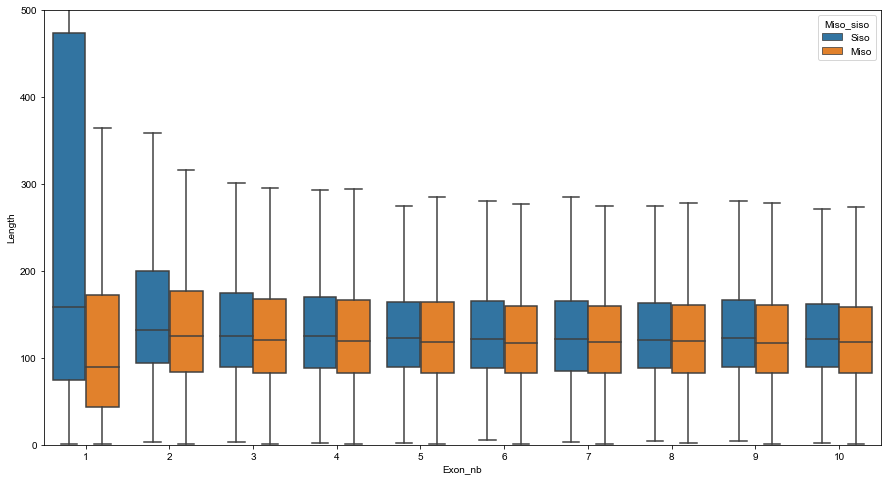

In [709]:
f, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=refseq_cds_dd.loc[refseq_cds_dd['Exon_nb'] <= 10], x='Exon_nb', y='Length', hue='Miso_siso', showfliers=False, ax=ax)
ax.set_ylim(0,500)


In [691]:
pd.merge(refseq_exons_utr_introns_exploded, refseq_genes[['Gene', 'Strand']].drop_duplicates(), on='Gene')

,Gene,RNA_name,ranges,Miso_siso,Introns,Intron_Start,Intron_End,Intron_Length,Strand
0,A1BG,NM_130786.4,"[58345183-58347029, 58347353-58347640, 5835037...",Siso,58347030-58347352,58347030,58347352,323,-
1,A1BG,NM_130786.4,"[58345183-58347029, 58347353-58347640, 5835037...",Siso,58347641-58350369,58347641,58350369,2729,-
2,A1BG,NM_130786.4,"[58345183-58347029, 58347353-58347640, 5835037...",Siso,58350652-58351390,58350652,58351390,739,-
3,A1BG,NM_130786.4,"[58345183-58347029, 58347353-58347640, 5835037...",Siso,58351688-58352282,58351688,58352282,595,-
4,A1BG,NM_130786.4,"[58345183-58347029, 58347353-58347640, 5835037...",Siso,58352556-58352927,58352556,58352927,372,-
...,...,...,...,...,...,...,...,...,...
681901,ZZZ3,NM_015534.6,"[77562416-77565784, 77566081-77566181, 7756833...",Miso,77584656-77631849,77584656,77631849,47194,-
681902,ZZZ3,NM_015534.6,"[77562416-77565784, 77566081-77566181, 7756833...",Miso,77633406-77639448,77633406,77639448,6043,-
681903,ZZZ3,NM_015534.6,"[77562416-77565784, 77566081-77566181, 7756833...",Miso,77639603-77641383,77639603,77641383,1781,-
681904,ZZZ3,NM_015534.6,"[77562416-77565784, 77566081-77566181, 7756833...",Miso,77641447-77641521,77641447,77641521,75,-


In [967]:
def order_exon_by_strand_and_seq(df, col="Intron_Start"):
    if df.Strand.unique()[0] == "-":
        df = df.sort_values(by=col, ascending=False)
    elif df.Strand.unique()[0] == "+":
        df = df.sort_values(by=col, ascending=True)
    df["Intron_nb"] = list(range(1, df.shape[0] + 1))
    df["Intron_nb_inverted"] =  list(np.array(list(range(1, df.shape[0] + 1))[::-1])*-1)

    return df

refseq_exons_utr_introns_exploded_intron_nb = pd.merge(refseq_exons_utr_introns_exploded, refseq_genes[['Gene', 'Strand']].drop_duplicates(), on='Gene')
refseq_exons_utr_introns_exploded_intron_nb_dd = refseq_exons_utr_introns_exploded_intron_nb.drop_duplicates(subset=['Gene', 'Intron_Start', 'Intron_Length'])
refseq_exons_utr_introns_exploded_intron_nb_dd = refseq_exons_utr_introns_exploded_intron_nb_dd.groupby(['Gene']).progress_apply(order_exon_by_strand_and_seq)

def describe_dev(df):
    d = df.describe().T
#     d['Diff%'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
#     print(d)
    d.loc['Sum'] = df.sum()
    
    return d

# refseq_exons_utr_introns_exploded_intron_nb_dd = refseq_exons_utr_introns_exploded_intron_nb.drop_duplicates(subset=['Gene', 'Intron_Start', 'Intron_Length'])
refseq_exons_utr_introns_exploded_intron_nb_dd_stats = describe_dev(refseq_exons_utr_introns_exploded_intron_nb_dd.loc[refseq_exons_utr_introns_exploded_intron_nb_dd['Intron_nb'] <= 10].groupby(['Miso_siso', 'Intron_nb'])['Intron_Length'])
refseq_exons_utr_introns_exploded_intron_nb_dd_stats


100%|██████████| 18285/18285 [01:49<00:00, 166.67it/s]


Miso_siso           Miso                                               \
Intron_nb             1              2              3              4    
count          11,363.00      11,324.00      11,121.00      10,715.00   
mean           15,943.83      14,350.70      12,719.11      10,518.02   
std            39,970.94      39,101.29      35,973.95      29,419.06   
min                 1.00          30.00          67.00          65.00   
25%               921.00         906.00         858.00         767.00   
50%             3,727.00       3,311.00       2,853.00       2,424.00   
75%            14,128.00      11,788.00       9,356.00       7,405.00   
max         1,043,910.00   1,160,411.00     846,682.00     874,944.00   
Sum       181,169,704.00 162,507,292.00 141,449,228.00 112,700,532.00   

Miso_siso                                                           \
Intron_nb             5             6             7             8    
count          10,211.00      9,618.00      8,981.00      8,289.00   
mean            9,802.00      8,679.71      8,238.18      8,011.10   
std            28,720.48     27,454.57     27,079.67     28,133.33   
min                26.00          1.00         54.00         67.00   
25%               699.50        654.00        639.00        596.00   
50%             2,177.00      2,076.00      1,948.00      1,906.00   
75%             6,889.50      5,967.75      5,611.00      5,455.00   
max           769,401.00    847,098.00  1,097,903.00    912,253.00   
Sum       100,088,217.00 83,481,459.00 73,987,137.00 66,404,005.00   

Miso_siso                                      Siso                \
Intron_nb            9             10            1             2    
count          7,608.00      7,009.00      6,922.00      5,955.00   
mean           7,569.49      7,176.37     11,841.40      7,533.77   
std           25,828.72     24,983.53     31,555.13     24,047.81   
min                1.00         68.00          0.00          1.00   
25%              615.00        578.00        900.25        568.50   
50%            1,798.00      1,801.00      2,892.00      1,822.00   
75%            5,259.00      4,860.00      9,819.50      5,215.00   
max          619,824.00    778,855.00    740,920.00    536,479.00   
Sum       57,588,691.00 50,299,181.00 81,966,180.00 44,863,581.00   

Miso_siso                                                          \
Intron_nb            3             4             5             6    
count          5,148.00      4,446.00      3,871.00      3,388.00   
mean           5,519.94      4,250.95      4,065.81      3,887.53   
std           16,549.00     12,614.75     14,224.81     12,284.92   
min               66.00          2.00         68.00          2.00   
25%              544.00        476.00        406.00        419.00   
50%            1,592.50      1,358.00      1,341.00      1,313.50   
75%            4,132.50      3,496.00      3,228.50      3,211.00   
max          387,853.00    266,238.00    460,671.00    248,959.00   
Sum       28,416,676.00 18,899,737.00 15,738,751.00 13,170,941.00   

Miso_siso                                                       
Intron_nb            7            8            9            10  
count          2,989.00     2,631.00     2,260.00     2,009.00  
mean           3,523.34     3,010.12     2,956.39     3,075.22  
std           15,504.30     7,485.49     6,717.06     7,432.73  
min               68.00         1.00         1.00         1.00  
25%              390.00       380.50       383.50       397.00  
50%            1,229.00     1,153.00     1,221.50     1,226.00  
75%            3,081.00     2,842.50     2,950.00     2,902.00  
max          721,292.00   167,631.00   127,958.00   153,581.00  
Sum       10,531,272.00 7,919,632.00 6,681,446.00 6,178,126.00

In [968]:
def order_exon_by_strand_and_seq(df, col="Intron_Start"):
    if df.Strand.unique()[0] == "-":
        df = df.sort_values(by=col, ascending=False)
    elif df.Strand.unique()[0] == "+":
        df = df.sort_values(by=col, ascending=True)
    df["Intron_nb"] = list(range(1, df.shape[0] + 1))
    df["Intron_nb_inverted"] =  list(np.array(list(range(1, df.shape[0] + 1))[::-1])*-1)

    return df


refseq_cds_introns_exploded_intron_nb = pd.merge(refseq_cds_introns_exploded, refseq_genes[['Gene', 'Strand']].drop_duplicates(), on='Gene')
refseq_cds_introns_exploded_intron_nb_dd = refseq_cds_introns_exploded_intron_nb.drop_duplicates(subset=['Gene', 'Intron_Start', 'Intron_Length'])
refseq_cds_introns_exploded_intron_nb_dd = refseq_cds_introns_exploded_intron_nb_dd.groupby(['Gene']).progress_apply(order_exon_by_strand_and_seq)


def describe_dev(df):
    d = df.describe().T
#     d['Diff%'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
#     print(d)
    d.loc['Sum'] = df.sum()
    return d

# refseq_cds_introns_exploded_intron_nb_dd = refseq_cds_introns_exploded_intron_nb.drop_duplicates(subset=['Gene', 'Intron_Start', 'Intron_Length'])
refseq_cds_introns_exploded_intron_nb_dd_stats = describe_dev(refseq_cds_introns_exploded_intron_nb_dd.loc[refseq_cds_introns_exploded_intron_nb_dd['Intron_nb'] <= 10].groupby(['Miso_siso', 'Intron_nb'])['Intron_Length'])
refseq_cds_introns_exploded_intron_nb_dd_stats



100%|██████████| 17281/17281 [01:37<00:00, 178.10it/s]


Miso_siso           Miso                                             \
Intron_nb             1              2             3             4    
count          10,973.00      10,676.00     10,318.00      9,717.00   
mean           16,238.04      12,079.18      9,454.43      8,204.37   
std            45,299.63      37,209.00     28,766.61     27,492.08   
min                 1.00          -1.00          1.00          1.00   
25%             1,039.00         796.00        698.00        658.00   
50%             3,670.00       2,549.00      2,189.00      2,008.00   
75%            12,499.00       8,184.25      6,430.00      5,595.00   
max         1,160,411.00     955,098.00    769,401.00    880,390.00   
Sum       178,180,053.00 128,957,297.00 97,550,842.00 79,721,867.00   

Miso_siso                                                          \
Intron_nb            5             6             7             8    
count          9,007.00      8,325.00      7,631.00      6,943.00   
mean           7,462.82      6,538.65      5,924.96      5,539.10   
std           27,805.31     21,218.83     19,177.89     19,538.39   
min               26.00          1.00         54.00         50.00   
25%              593.00        573.00        560.00        515.50   
50%            1,830.00      1,762.00      1,711.00      1,608.00   
75%            4,956.00      4,599.00      4,515.50      4,274.00   
max        1,097,903.00    619,824.00    532,642.00    619,827.00   
Sum       67,217,656.00 54,434,276.00 45,213,347.00 38,458,005.00   

Miso_siso                                      Siso                \
Intron_nb            9             10            1             2    
count          6,315.00      5,722.00      6,308.00      5,556.00   
mean           5,474.99      5,174.96     11,968.31      6,318.66   
std           20,150.16     14,604.23     34,493.87     19,229.71   
min               67.00         66.00          0.00          1.00   
25%              542.00        512.00        846.00        568.00   
50%            1,628.00      1,620.50      2,708.50      1,748.00   
75%            4,188.50      4,233.75      9,238.25      4,706.75   
max          778,855.00    372,394.00    740,920.00    350,884.00   
Sum       34,574,545.00 29,611,095.00 75,496,084.00 35,106,449.00   

Miso_siso                                                          \
Intron_nb            3             4             5             6    
count          4,882.00      4,193.00      3,688.00      3,218.00   
mean           4,869.39      4,167.41      4,027.84      3,663.62   
std           14,912.29     14,886.74     12,705.43     10,286.19   
min                2.00         67.00         68.00          2.00   
25%              495.00        443.00        378.50        414.50   
50%            1,454.50      1,327.00      1,311.50      1,288.50   
75%            3,740.75      3,339.00      3,219.75      3,156.75   
max          387,853.00    460,671.00    248,959.00    236,772.00   
Sum       23,772,343.00 17,473,931.00 14,854,682.00 11,789,545.00   

Miso_siso                                                      
Intron_nb           7            8            9            10  
count         2,824.00     2,509.00     2,172.00     1,912.00  
mean          3,322.98     2,982.75     3,007.55     3,124.40  
std          15,625.55     7,255.45     6,794.46     7,592.55  
min               1.00         2.00         1.00        65.00  
25%             378.75       382.00       384.75       371.75  
50%           1,166.50     1,208.00     1,248.50     1,178.50  
75%           2,990.00     2,822.00     2,961.50     2,964.25  
max         721,292.00   167,631.00   127,958.00   153,581.00  
Sum       9,384,103.00 7,483,716.00 6,532,405.00 5,973,847.00

In [973]:
refseq_exons_utr_introns_exploded_intron_nb_dd.loc[(refseq_exons_utr_introns_exploded_intron_nb_dd['Intron_nb_inverted'] >= -10) & (~refseq_exons_utr_dd['Gene'].isin(tmp_exons_utr_single_exon))]

,,Gene,RNA_name,ranges,Miso_siso,Introns,Intron_Start,Intron_End,Intron_Length,Strand,Intron_nb,Intron_nb_inverted
Gene,,,,,,,,,,,,


In [979]:


tmp_exons_utr = pd.merge(pd.DataFrame(refseq_exons_utr.reset_index(drop=True).drop_duplicates(subset=['Gene', 'ranges']).groupby(['Gene'])['ranges'].count()), miso_siso[['Gene', 'Miso_siso']], on='Gene')
tmp_exons_utr_single_exon = tmp_exons_utr.loc[tmp_exons_utr['ranges'] == 1]['Gene'].values.tolist()


tmp_cds = pd.merge(pd.DataFrame(refseq_cds.reset_index(drop=True).drop_duplicates(subset=['Gene', 'ranges']).groupby(['Gene'])['ranges'].count()), miso_siso[['Gene', 'Miso_siso']], on='Gene')
tmp_cds_genes_single_cds = tmp_cds.loc[tmp_cds['ranges'] == 1]['Gene'].values.tolist()


def describe_dev(df):
    d = df.describe().T
#     d['Diff%'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
#     print(d)
    d.loc['Sum'] = df.sum()
    
    return d


concat_stats = [
    describe_dev(refseq_exons_utr_dd.loc[(refseq_exons_utr_dd['Exon_nb'] <= 10) & (~refseq_exons_utr_dd['Gene'].isin(tmp_exons_utr_single_exon))].groupby(['Miso_siso', 'Exon_nb'])['Length']),
#     describe_dev(refseq_exons_utr_dd.loc[(refseq_exons_utr_dd['Exon_nb_inverted'] >= -10) & (~refseq_exons_utr_dd['Gene'].isin(tmp_exons_utr_single_exon))].groupby(['Miso_siso', 'Exon_nb_inverted'])['Length']),
    
    describe_dev(refseq_cds_dd.loc[(refseq_cds_dd['Exon_nb'] <= 10) & (~refseq_cds_dd['Gene'].isin(tmp_cds_genes_single_cds))].groupby(['Miso_siso', 'Exon_nb'])['Length']),
#     describe_dev(refseq_cds_dd.loc[(refseq_cds_dd['Exon_nb_inverted'] >= -10) & (~refseq_cds_dd['Gene'].isin(tmp_cds_genes_single_cds))].groupby(['Miso_siso', 'Exon_nb_inverted'])['Length']),
    
    describe_dev(refseq_exons_utr_introns_exploded_intron_nb_dd.loc[(refseq_exons_utr_introns_exploded_intron_nb_dd['Intron_nb'] <= 10)  & (~refseq_exons_utr_introns_exploded_intron_nb_dd['Gene'].isin(tmp_exons_utr_single_exon))].groupby(['Miso_siso', 'Intron_nb'])['Intron_Length']),
#     describe_dev(refseq_exons_utr_introns_exploded_intron_nb_dd.loc[(refseq_exons_utr_introns_exploded_intron_nb_dd['Intron_nb_inverted'] >= -10) & (~refseq_exons_utr_introns_exploded_intron_nb_dd['Gene'].isin(tmp_exons_utr_single_exon))].groupby(['Miso_siso', 'Intron_nb_inverted'])['Intron_Length']),
    
    describe_dev(refseq_cds_introns_exploded_intron_nb_dd.loc[(refseq_cds_introns_exploded_intron_nb_dd['Intron_nb'] <= 10) & (~refseq_cds_introns_exploded_intron_nb_dd['Gene'].isin(tmp_cds_genes_single_cds)) ].groupby(['Miso_siso', 'Intron_nb'])['Intron_Length']),
#     describe_dev(refseq_cds_introns_exploded_intron_nb_dd.loc[(refseq_cds_introns_exploded_intron_nb_dd['Intron_nb_inverted'] >= -10 ) & (~refseq_cds_introns_exploded_intron_nb_dd['Gene'].isin(tmp_cds_genes_single_cds))].groupby(['Miso_siso', 'Intron_nb_inverted'])['Intron_Length']),
]
concat_stats = pd.concat(concat_stats).T

concat_stats.columns = pd.MultiIndex.from_product([['Exon', 'CDS', 'Intron/Exon', 'Intron/CDS'], ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Sum']])
concat_stats = concat_stats.T
concat_stats

# concat_ordinal = pd.concat(
#     [
#         refseq_exons_utr_ordinal_stats,
#         refseq_cds_dd_stats,
#         refseq_exons_utr_introns_exploded_intron_nb_dd_stats
#     ]
#     )
# concat_ordinal = concat_ordinal.T
# concat_ordinal.columns = pd.MultiIndex.from_product([['Exon', 'CDS', 'Intron'], ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Sum']])
# concat_ordinal.T.to_excel('/gstock/GeneIso/results/3B_exon_cds_intron_length_ordinal.xlsx')
# concat_ordinal.T

Miso_siso                   Miso                                               \
Exon_nb                       1              2              3              4    
Exon        count      11,366.00      11,366.00      11,363.00      11,137.00   
            mean          251.40         226.68         271.93         289.46   
            std           304.89         395.64         654.03         684.53   
            min             8.00           4.00           3.00           3.00   
            25%           101.00          88.00          89.00          90.00   
            50%           168.00         135.00         133.00         131.00   
            75%           292.00         223.00         216.00         201.00   
            max         6,388.00      12,708.00      27,561.00      15,922.00   
            Sum     2,857,420.00   2,576,478.00   3,089,915.00   3,223,699.00   
CDS         count      10,995.00      10,995.00      10,825.00      10,487.00   
            mean          177.54         183.46         176.29         169.90   
            std           322.93         319.95         321.99         268.66   
            min             1.00           1.00           1.00           1.00   
            25%            49.00          73.00          77.00          79.00   
            50%            94.00         117.00         118.00         118.00   
            75%           177.00         173.00         170.00         168.00   
            max         6,045.00      12,707.00      17,330.00       6,876.00   
            Sum     1,952,065.00   2,017,091.00   1,908,384.00   1,781,696.00   
Intron/Exon count      11,363.00      11,324.00      11,121.00      10,715.00   
            mean       15,943.83      14,350.70      12,719.11      10,518.02   
            std        39,970.94      39,101.29      35,973.95      29,419.06   
            min             1.00          30.00          67.00          65.00   
            25%           921.00         906.00         858.00         767.00   
            50%         3,727.00       3,311.00       2,853.00       2,424.00   
            75%        14,128.00      11,788.00       9,356.00       7,405.00   
            max     1,043,910.00   1,160,411.00     846,682.00     874,944.00   
            Sum   181,169,704.00 162,507,292.00 141,449,228.00 112,700,532.00   
Intron/CDS  count      10,972.00      10,676.00      10,318.00       9,717.00   
            mean       16,239.27      12,079.18       9,454.43       8,204.37   
            std        45,301.51      37,209.00      28,766.61      27,492.08   
            min             1.00          -1.00           1.00           1.00   
            25%         1,039.00         796.00         698.00         658.00   
            50%         3,670.00       2,549.00       2,189.00       2,008.00   
            75%        12,501.25       8,184.25       6,430.00       5,595.00   
            max     1,160,411.00     955,098.00     769,401.00     880,390.00   
            Sum   178,177,274.00 128,957,297.00  97,550,842.00  79,721,867.00   

Miso_siso                                                                   \
Exon_nb                       5             6             7             8    
Exon        count      10,703.00     10,128.00      9,439.00      8,715.00   
            mean          317.16        351.16        344.31        359.75   
            std           750.66        988.99        885.32        964.62   
            min             3.00          2.00          4.00          3.00   
            25%            91.00         90.00         92.00         90.00   
            50%           130.00        130.00        131.00        129.00   
            75%           194.00        194.00        193.00        192.00   
            max        10,546.00     33,290.00     18,173.00     23,264.00   
            Sum     3,394,540.00  3,556,550.00  3,249,903.00  3,135,194.00   
CDS         count       9,955.00      9,247.00      8,464.00   

In [981]:


tmp_exons_utr = pd.merge(pd.DataFrame(refseq_exons_utr.reset_index(drop=True).drop_duplicates(subset=['Gene', 'ranges']).groupby(['Gene'])['ranges'].count()), miso_siso[['Gene', 'Miso_siso']], on='Gene')
tmp_exons_utr_single_exon = tmp_exons_utr.loc[tmp_exons_utr['ranges'] == 1]['Gene'].values.tolist()


tmp_cds = pd.merge(pd.DataFrame(refseq_cds.reset_index(drop=True).drop_duplicates(subset=['Gene', 'ranges']).groupby(['Gene'])['ranges'].count()), miso_siso[['Gene', 'Miso_siso']], on='Gene')
tmp_cds_genes_single_cds = tmp_cds.loc[tmp_cds['ranges'] == 1]['Gene'].values.tolist()


def describe_dev(df):
    d = df.describe().T
#     print(d.columns)
#     d['Diff%'] = 100 * (d['Miso'] - d['Siso']) / d['Miso']
#     print(d)
    d.loc['Sum'] = df.sum()
    
    return d


concat_stats = [
#     describe_dev(refseq_exons_utr_dd.loc[(refseq_exons_utr_dd['Exon_nb'] <= 10) & (~refseq_exons_utr_dd['Gene'].isin(tmp_exons_utr_single_exon))].groupby(['Miso_siso', 'Exon_nb'])['Length']),
    describe_dev(refseq_exons_utr_dd.loc[(refseq_exons_utr_dd['Exon_nb_inverted'] >= -10) & (~refseq_exons_utr_dd['Gene'].isin(tmp_exons_utr_single_exon))].groupby(['Miso_siso', 'Exon_nb_inverted'])['Length']),
    
#     describe_dev(refseq_cds_dd.loc[(refseq_cds_dd['Exon_nb'] <= 10) & (~refseq_cds_dd['Gene'].isin(tmp_cds_genes_single_cds))].groupby(['Miso_siso', 'Exon_nb'])['Length']),
    describe_dev(refseq_cds_dd.loc[(refseq_cds_dd['Exon_nb_inverted'] >= -10) & (~refseq_cds_dd['Gene'].isin(tmp_cds_genes_single_cds))].groupby(['Miso_siso', 'Exon_nb_inverted'])['Length']),
    
#     describe_dev(refseq_exons_utr_introns_exploded_intron_nb_dd.loc[(refseq_exons_utr_introns_exploded_intron_nb_dd['Intron_nb'] <= 10)  & (~refseq_exons_utr_introns_exploded_intron_nb_dd['Gene'].isin(tmp_exons_utr_single_exon))].groupby(['Miso_siso', 'Intron_nb'])['Intron_Length']),
    describe_dev(refseq_exons_utr_introns_exploded_intron_nb_dd.loc[(refseq_exons_utr_introns_exploded_intron_nb_dd['Intron_nb_inverted'] >= -10) & (~refseq_exons_utr_introns_exploded_intron_nb_dd['Gene'].isin(tmp_exons_utr_single_exon))].groupby(['Miso_siso', 'Intron_nb_inverted'])['Intron_Length']),
    
#     describe_dev(refseq_cds_introns_exploded_intron_nb_dd.loc[(refseq_cds_introns_exploded_intron_nb_dd['Intron_nb'] <= 10) & (~refseq_cds_introns_exploded_intron_nb_dd['Gene'].isin(tmp_cds_genes_single_cds)) ].groupby(['Miso_siso', 'Intron_nb'])['Intron_Length']),
    describe_dev(refseq_cds_introns_exploded_intron_nb_dd.loc[(refseq_cds_introns_exploded_intron_nb_dd['Intron_nb_inverted'] >= -10 ) & (~refseq_cds_introns_exploded_intron_nb_dd['Gene'].isin(tmp_cds_genes_single_cds))].groupby(['Miso_siso', 'Intron_nb_inverted'])['Intron_Length']),
]
concat_stats = pd.concat(concat_stats).T

concat_stats.columns = pd.MultiIndex.from_product([['Exon', 'CDS', 'Intron/Exon', 'Intron/CDS'], ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Sum']])
concat_stats = concat_stats.T
concat_stats

# concat_ordinal = pd.concat(
#     [
#         refseq_exons_utr_ordinal_stats,
#         refseq_cds_dd_stats,
#         refseq_exons_utr_introns_exploded_intron_nb_dd_stats
#     ]
#     )
# concat_ordinal = concat_ordinal.T
# concat_ordinal.columns = pd.MultiIndex.from_product([['Exon', 'CDS', 'Intron'], ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Sum']])
# concat_ordinal.T.to_excel('/gstock/GeneIso/results/3B_exon_cds_intron_length_ordinal.xlsx')
# concat_ordinal.T

Miso_siso                  Miso                                            \
Exon_nb_inverted            -10           -9            -8            -7    
Exon        count      7,305.00      7,982.00      8,715.00      9,439.00   
            mean         177.05        167.24        173.88        180.01   
            std          288.41        223.68        244.68        313.47   
            min            3.00          5.00          6.00          3.00   
            25%           88.00         89.00         88.00         88.00   
            50%          126.00        124.00        126.00        127.00   
            75%          177.00        175.00        178.00        179.00   
            max        9,822.00      7,812.00      8,791.00     15,173.00   
            Sum    1,293,338.00  1,334,881.00  1,515,395.00  1,699,148.00   
CDS         count      6,398.00      7,059.00      7,725.00      8,464.00   
            mean         141.26        138.81        145.67        143.90   
            std          182.77        146.87        207.89        181.11   
            min            1.00          1.00          1.00          1.00   
            25%           78.00         79.00         80.00         79.00   
            50%          115.00        115.00        116.00        116.00   
            75%          158.00        158.00        161.00        161.00   
            max        4,686.00      3,408.00      7,811.00      5,060.00   
            Sum      903,778.00    979,848.00  1,125,301.00  1,217,973.00   
Intron/Exon count      7,009.00      7,608.00      8,289.00      8,981.00   
            mean       8,449.84      7,989.64      7,183.40      7,255.59   
            std       27,381.57     27,230.67     22,520.14     22,283.15   
            min           66.00         69.00          1.00         62.00   
            25%          633.00        635.50        591.00        579.00   
            50%        2,079.00      1,959.50      1,865.00      1,810.00   
            75%        6,092.00      5,685.50      5,417.00      5,390.00   
            max    1,043,910.00  1,097,903.00    912,253.00    501,759.00   
            Sum   59,224,957.00 60,785,169.00 59,543,204.00 65,162,490.00   
Intron/CDS  count      5,722.00      6,315.00      6,943.00      7,631.00   
            mean       7,596.19      7,421.40      6,656.81      6,738.94   
            std       28,166.82     23,756.42     23,308.92     21,942.02   
            min           66.00          1.00          1.00         62.00   
            25%          573.00        560.50        579.50        540.50   
            50%        1,895.50      1,847.00      1,755.00      1,730.00   
            75%        5,231.75      5,019.00      4,806.00      4,931.50   
            max    1,043,910.00    508,461.00  1,097,903.00    501,759.00   
            Sum   43,465,392.00 46,866,168.00 46,218,230.00 51,424,859.00   

Miso_siso                                                                  \
Exon_nb_inverted            -6            -5            -4            -3    
Exon        count     10,128.00     10,703.00     11,137.00     11,363.00   
            mean         186.81        206.28        227.25        296.54   
            std          340.56        481.05        555.99        802.55   
            min            4.00          3.00          2.00          4.00   
            25%           89.00         91.00         92.00         93.00   
            50%          127.00        128.00        128.00        128.00   
            75%          176.00        176.00        179.00        187.00   
            max       11,807.00     27,561.00     14,417.00     30,081.00   
            Sum    1,892,031.00  2,207,768.00  2,530,895.00  3,369,562.00   
CDS         count      9,247.00      9,955.00     10,487.00     10,825.00   
            mean         147.81        162.48        166.93        166.60   
            std          197.53        258.03        270.64        296.1

In [1457]:
single_exons = refseq_cds.groupby(['Gene', 'RNA_name'])['ranges'].count().reset_index()
single_exons = single_exons.loc[single_exons['ranges'] > 1]
single_exons

,Gene,RNA_name,ranges
0,A1BG,NM_130786.4,8
1,A1CF,NM_001198818.2,11
2,A1CF,NM_001198819.2,11
3,A1CF,NM_001198820.2,11
4,A1CF,NM_001370130.1,11
...,...,...,...
62266,ZZZ3,NM_001376153.1,11
62267,ZZZ3,NM_001376154.1,11
62268,ZZZ3,NM_001376155.1,11
62269,ZZZ3,NM_001376156.1,11


In [1455]:
single_exons.loc[single_exons['Gene'].str.contains('^OR')].drop_duplicates(subset=['Gene']).ranges.value_counts()

1     381
2       8
3       4
16      2
6       2
15      1
14      1
13      1
7       1
Name: ranges, dtype: int64

,count,mean,std,min,25%,50%,75%,max
Miso_siso,,,,,,,,
Miso,"10,971.00","2,173.19","2,086.05",75.00,"1,084.00","1,693.00","2,649.50","114,068.00"
Siso,"6,307.00","1,705.88","1,881.58",84.00,723.50,"1,217.00","1,936.00","43,440.00"


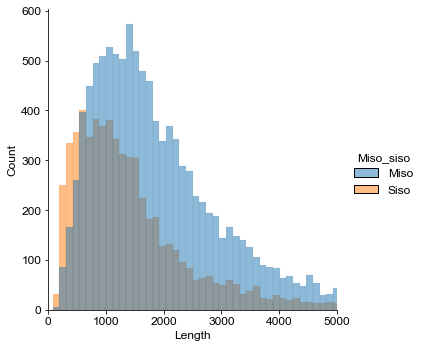

In [1465]:
data = refseq_cds.loc[refseq_cds['Gene'].isin(single_exons.Gene.unique().tolist())].drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso',  'Gene'])['Length'].sum().reset_index()
sns.displot(data, x='Length', hue='Miso_siso')
plt.xlim(0,5000)
refseq_cds.loc[refseq_cds['Gene'].isin(single_exons.Gene.unique().tolist())].drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso',  'Gene'])['Length'].sum().groupby('Miso_siso').describe()

,count,mean,std,min,25%,50%,75%,max
Miso_siso,,,,,,,,
Miso,"10,971.00",13.69,10.81,2.00,7.00,11.00,18.00,363.00
Siso,"6,307.00",9.94,10.78,2.00,4.00,7.00,12.00,172.00


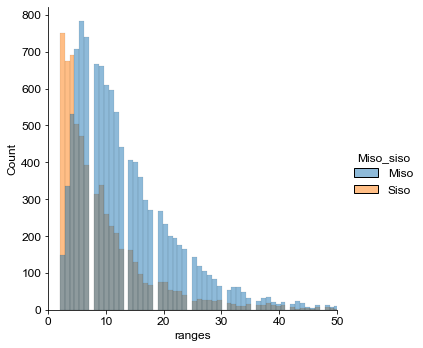

In [1464]:
data = refseq_cds.loc[refseq_cds['Gene'].isin(single_exons.Gene.unique().tolist())].drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso',  'Gene'])['ranges'].count().reset_index()
sns.displot(data, x='ranges', hue='Miso_siso')
plt.xlim(0,50)
refseq_cds.loc[refseq_cds['Gene'].isin(single_exons.Gene.unique().tolist())].drop_duplicates(subset=['Gene', 'Start', 'End']).groupby(['Miso_siso',  'Gene'])['ranges'].count().groupby('Miso_siso').describe()

In [989]:
refseq_cds_dd.loc[refseq_cds_dd['Gene'] == 'A1BG']

NC RefSeq_validation Region_type     Start       End  \
Gene                                                                          
A1BG 615568  NC_000019.10        BestRefSeq         CDS  58353404  58353437   
     615569  NC_000019.10        BestRefSeq         CDS  58353292  58353327   
     615570  NC_000019.10        BestRefSeq         CDS  58352928  58353197   
     615571  NC_000019.10        BestRefSeq         CDS  58352283  58352555   
     615572  NC_000019.10        BestRefSeq         CDS  58351391  58351687   
     615573  NC_000019.10        BestRefSeq         CDS  58350370  58350651   
     615574  NC_000019.10        BestRefSeq         CDS  58347353  58347640   
     615575  NC_000019.10        BestRefSeq         CDS  58347022  58347029   

            Score Strand Phase  \
Gene                             
A1BG 615568     .      -     0   
     615569     .      -     2   
     615570     .      -     2   
     615571     .      -     2   
     615572     .      -     2   
     615573     .      -     2   
     615574     .      -     2   
     615575     .      -     2   

                                                    Attributes  Length  Gene  \
Gene                                                                           
A1BG 615568  ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...      33  A1BG   
     615569  ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...      35  A1BG   
     615570  ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...     269  A1BG   
     615571  ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...     272  A1BG   
     615572  ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...     296  A1BG   
     615573  ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...     281  A1BG   
     615574  ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...     287  A1BG   
     615575  ID=cds-NP_570602.2;Parent=rna-NM_130786.4;Dbxr...       7  A1BG   

                      NP Miso_siso             ranges  Exon_nb  \
Gene                                                             
A1BG 615568  NP_570602.2      Siso  58353404-58353437        1   
     615569  NP_570602.2      Siso  58353292-58353327        2   
     615570  NP_570602.2      Siso  58352928-58353197        3   
     615571  NP_570602.2      Siso  58352283-58352555        4   
     615572  NP_570602.2      Siso  58351391-58351687        5   
     615573  NP_570602.2      Siso  58350370-58350651        6   
     615574  NP_570602.2      Siso  58347353-58347640        7   
     615575  NP_570602.2      Siso  58347022-58347029        8   

             Exon_nb_inverted  
Gene                           
A1BG 615568                -8  
     615569                -7  
     615570                -6  
     615571                -5  
     615572                -4  
     615573                -3  
     615574                -2  
     615575                -1

In [990]:
refseq_exons_utr_dd.loc[refseq_exons_utr_dd['Gene'] == 'A1BG']

NC RefSeq_validation Region_type     Start       End  \
Gene                                                                          
A1BG 679833  NC_000019.10        BestRefSeq        exon  58353404  58353492   
     679834  NC_000019.10        BestRefSeq        exon  58353292  58353327   
     679835  NC_000019.10        BestRefSeq        exon  58352928  58353197   
     679836  NC_000019.10        BestRefSeq        exon  58352283  58352555   
     679837  NC_000019.10        BestRefSeq        exon  58351391  58351687   
     679838  NC_000019.10        BestRefSeq        exon  58350370  58350651   
     679839  NC_000019.10        BestRefSeq        exon  58347353  58347640   
     679840  NC_000019.10        BestRefSeq        exon  58345183  58347029   

            Score Strand Phase  \
Gene                             
A1BG 679833     .      -     .   
     679834     .      -     .   
     679835     .      -     .   
     679836     .      -     .   
     679837     .      -     .   
     679838     .      -     .   
     679839     .      -     .   
     679840     .      -     .   

                                                    Attributes     RNA_name  \
Gene                                                                          
A1BG 679833  ID=exon-NM_130786.4-1;Parent=rna-NM_130786.4;D...  NM_130786.4   
     679834  ID=exon-NM_130786.4-2;Parent=rna-NM_130786.4;D...  NM_130786.4   
     679835  ID=exon-NM_130786.4-3;Parent=rna-NM_130786.4;D...  NM_130786.4   
     679836  ID=exon-NM_130786.4-4;Parent=rna-NM_130786.4;D...  NM_130786.4   
     679837  ID=exon-NM_130786.4-5;Parent=rna-NM_130786.4;D...  NM_130786.4   
     679838  ID=exon-NM_130786.4-6;Parent=rna-NM_130786.4;D...  NM_130786.4   
     679839  ID=exon-NM_130786.4-7;Parent=rna-NM_130786.4;D...  NM_130786.4   
     679840  ID=exon-NM_130786.4-8;Parent=rna-NM_130786.4;D...  NM_130786.4   

             Length  Gene             ranges Miso_siso  Exon_nb  \
Gene                                                              
A1BG 679833      89  A1BG  58353404-58353492      Siso        1   
     679834      36  A1BG  58353292-58353327      Siso        2   
     679835     270  A1BG  58352928-58353197      Siso        3   
     679836     273  A1BG  58352283-58352555      Siso        4   
     679837     297  A1BG  58351391-58351687      Siso        5   
     679838     282  A1BG  58350370-58350651      Siso        6   
     679839     288  A1BG  58347353-58347640      Siso        7   
     679840    1847  A1BG  58345183-58347029      Siso        8   

             Exon_nb_inverted  
Gene                           
A1BG 679833                -8  
     679834                -7  
     679835                -6  
     679836                -5  
     679837                -4  
     679838                -3  
     679839                -2  
     679840                -1

In [826]:
concat_ordinal = pd.concat(
    [
        refseq_exons_utr_ordinal_stats,
        refseq_cds_dd_stats,
        refseq_exons_utr_introns_exploded_intron_nb_dd_stats
    ]
    )
concat_ordinal = concat_ordinal.T
concat_ordinal.columns = pd.MultiIndex.from_product([['Exon', 'CDS', 'Intron'], ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'Sum']])
concat_ordinal.T.to_excel('/gstock/GeneIso/results/3B_exon_cds_intron_length_ordinal.xlsx')
concat_ordinal.T

Miso_siso              Miso                                              \
Exon_nb                  1              2              3             4    
Exon   count      22,475.00      16,532.00      14,151.00     12,521.00   
       mean          265.13         273.56         298.14        359.94   
       std           371.78         722.27         702.68        931.69   
       min             8.00           2.00           3.00          6.00   
       25%           101.00          88.00          89.00         90.00   
       50%           172.00         129.00         127.00        129.00   
       75%           306.00         199.00         191.00        193.00   
       max        12,344.00      33,290.00      14,751.00     30,081.00   
       Sum     5,958,902.00   4,522,483.00   4,218,945.00  4,506,797.00   
CDS    count      19,895.00      14,626.00      13,066.00     11,647.00   
       mean          198.14         181.43         167.84        169.66   
       std           380.92         283.99         290.93        292.83   
       min             1.00           1.00           1.00          1.00   
       25%            44.00          84.00          83.00         82.00   
       50%            90.00         125.00         120.00        119.00   
       75%           172.00         177.00         168.00        167.00   
       max         6,045.00      12,707.00      17,330.00     16,736.00   
       Sum     3,942,036.00   2,653,658.00   2,192,993.00  1,976,029.00   
Intron count      27,093.00      18,283.00      14,859.00     12,444.00   
       mean       17,942.33      14,268.46       9,947.56      7,474.38   
       std        43,200.92      39,280.11      28,916.82     22,970.65   
       min             1.00          28.00          55.00          1.00   
       25%         1,110.00         955.00         752.50        636.00   
       50%         4,561.00       3,151.00       2,373.00      1,910.00   
       75%        17,000.00      10,618.00       7,038.50      5,291.50   
       max     1,097,903.00   1,160,411.00     772,519.00    619,827.00   
       Sum   486,111,678.00 260,870,335.00 147,810,838.00 93,011,151.00   

Miso_siso                                                             \
Exon_nb                 5             6             7             8    
Exon   count     11,115.00      9,847.00      8,658.00      7,659.00   
       mean         376.44        386.12        381.25        373.24   
       std          970.17      1,006.82      1,048.14      1,012.67   
       min            3.00          3.00          3.00          6.00   
       25%           92.00         91.00         91.00         90.00   
       50%          130.00        129.00        130.00        128.00   
       75%          192.00        188.00        187.00        185.50   
       max       23,264.00     18,260.00     24,764.00     18,360.00   
       Sum    4,184,111.00  3,802,106.00  3,300,824.00  2,858,649.00   
CDS    count     10,114.00      8,923.00      7,922.00      7,000.00   
       mean         157.08        146.46        145.70        146.99   
       std          250.34        204.58        206.54        204.02   
       min            1.00          1.00          1.00          2.00   
       25%           83.00         82.00         83.00         83.00   
       50%          118.00        117.00        118.00        119.00   
       75%          164.00        160.00        160.00        161.00   
       max       11,554.00      9,378.00      6,577.00      6,597.00   
       Sum    1,588,711.00  1,306,903.00  1,154,270.00  1,028,925.00   
Intron count     10,715.00      9,219.00      8,088.00      7,216.00   
       mean       6,443.07      5,467.71      5,300.76      4,773.75   
       std       20,540.31     16,331.83     17,870.29     11,667.00   
       min            1.00         43.00         56.00         47.00   
       25%          583.00        577.00        527.00        525.00   
       50%        1,795.

In [1415]:
rcParams['font.size'] = 12

def custom_boxplot(data, x, y, hue, ax, ylim, title="Title",xlabel="",ylabel="", box_pairs=[()], palette=['grey'], id_string="A", padding_value_boxplot=1, padding_title=10, legend=False, x_legend=0):

    if x:
        data = data.sort_values(by=hue,ascending=True)
#         data[x] = data[x].astype(str)
#         sns.boxplot(data=data, x=x, y=y, hue=hue, showfliers=True, ax=ax, palette=palette, showmeans=True, meanline=False, 
#                     meanprops={"marker":"o","markerfacecolor":"grey", "markeredgecolor":"black", "markersize" : 10})
        sns.boxplot(data=data, x=x, y=y, hue=hue, showfliers=False, ax=ax, palette=palette, )
    else:
        sns.boxplot(data=data, y=y, showfliers=False, ax=ax, palette=palette)
        
    ax.set_title(title, pad=padding_title)
    ax.set_ylim(ylim)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
#     if x == 'Intron_nb':
#         ax.set_xlabel('Ordinal position')
#     else:
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Length (bp)')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    if not x: 
        ax.spines['bottom'].set_linewidth(0)

        ax.axes.xaxis.set_visible(False)
    ax.set_axisbelow(True)

    ax.grid(axis='y')
    
    if legend is True:
    
        handles, labels = ax.get_legend_handles_labels()

        ax.legend(handles= 
                  [ 
                     mpatches.Patch([0], [0], color=palette['Miso'],),
                    mpatches.Patch([0], [0], color=palette['Siso'], ),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15),
                    matplotlib.lines.Line2D([0], [0], color='black', lw=1)
                    ],  
              labels= ['Miso', 'Siso', 'Mean', "Median"], title='', ncol=1, bbox_to_anchor=(x_legend,0.75), loc='center right')
    else:
        ax.legend().remove()

    means = data.groupby([hue, x])[y].mean().reset_index()
    medians = data.groupby([hue, x])[y].median().reset_index()
    for ms, x_shift in zip(['Miso', 'Siso'], [-0.225,0.225]):
        tmp_df_means = means.loc[means['Miso_siso'] == ms]
#         print(tmp_df_means)
#         print(ms, x_shift, x, y, hue, tmp_df_means[x].max())
    #     print(tmp_df)
    #     print(tmp_df.Intron_nb)
    #     print(tmp_df.Intron_nb.max())
        x_plot = [e + x_shift for e in range(0,5)]
#         if 'inverted' in x:
#             print(tmp_df_means[x].min())
#             x_plot = [e + x_shift for e in range(int(tmp_df_means[x].min()), 0)]
#             print(x_plot)

#         x_plot = [0,1,2,3,4]
        ax.plot(x_plot, tmp_df_means[y].values, lw=2, color=palette[ms],  marker="o", markersize=12, markeredgecolor="black")

        
    if x: 
        add_stat_annotation(ax, data=data, x=x, y=y, hue=hue, box_pairs=box_pairs,
                            test='Mann-Whitney', text_format='star',
                            loc='outside', verbose=2)
#     return ax



In [1379]:
def invert_nb_exon_utr(df):
#     print(df)
    five_prime_positions = df.loc[df['UTR_bool'] == '5_prime']['Nb_exon'].values
#     print(five_prime_positions)
    three_prime_positions = df.loc[df['UTR_bool'] == '3_prime']['Nb_exon'].values
#     print(three_prime_positions)
#     if five_prime_positions.tolist() and three_prime_positions.tolist():
#         five_prime_positions = five_prime_positions - 1 - three_prime_positions.max()
#         print(five_prime_positions)
    
    if three_prime_positions.tolist():
        three_prime_positions = three_prime_positions - 1 - three_prime_positions.max()
        df.loc[df['UTR_bool'] == '3_prime', 'Nb_exon_inverted'] = three_prime_positions
    return df
#         print(three_prime_positions)
#     print('\n')


utrs_test = utrs.groupby(['Gene', 'RNA_name']).progress_apply(invert_nb_exon_utr)
utrs_test

100%|██████████| 61976/61976 [04:17<00:00, 240.81it/s]


,NC,RefSeq_validation,Type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,RNA_name,Miso_siso,ranges,UTR_ranges,UTR_bool,Nb_exon,UTR_Start,UTR_End,UTR_Length,Nb_exon_inverted
0,NC_000019.10,BestRefSeq,exon,58353404,58353492,.,-,.,ID=exon-NM_130786.4-1;Parent=rna-NM_130786.4;D...,89,A1BG,NaN,NM_130786.4,Siso,58353404-58353492,58353438-58353492,5_prime,1.00,58353438,58353492,54,nan
1,NC_000019.10,BestRefSeq,exon,58345183,58347029,.,-,.,ID=exon-NM_130786.4-8;Parent=rna-NM_130786.4;D...,1847,A1BG,NaN,NM_130786.4,Siso,58345183-58347029,58345183-58347021,3_prime,8.00,58345183,58347021,1838,-1.00
2,NC_000010.11,BestRefSeq,exon,50885581,50885627,.,-,.,ID=exon-NM_001198818.2-1;Parent=rna-NM_0011988...,47,A1CF,NaN,NM_001198818.2,Miso,50885581-50885627,50885581-50885627,5_prime,1.00,50885581,50885627,46,nan
3,NC_000010.11,BestRefSeq,exon,50864033,50864080,.,-,.,ID=exon-NM_001198818.2-2;Parent=rna-NM_0011988...,48,A1CF,NaN,NM_001198818.2,Miso,50864033-50864080,50864033-50864080,5_prime,2.00,50864033,50864080,47,nan
4,NC_000010.11,BestRefSeq,exon,50862889,50862981,.,-,.,ID=exon-NM_001198818.2-3;Parent=rna-NM_0011988...,93,A1CF,NaN,NM_001198818.2,Miso,50862889-50862981,50862889-50862981,5_prime,3.00,50862889,50862981,92,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187462,NC_000001.11,BestRefSeq,exon,77641522,77641655,.,-,.,ID=exon-NM_015534.6-2;Parent=rna-NM_015534.6;D...,134,ZZZ3,NaN,NM_015534.6,Miso,77641522-77641655,77641522-77641655,5_prime,2.00,77641522,77641655,133,nan
187463,NC_000001.11,BestRefSeq,exon,77641384,77641446,.,-,.,ID=exon-NM_015534.6-3;Parent=rna-NM_015534.6;D...,63,ZZZ3,NaN,NM_015534.6,Miso,77641384-77641446,77641384-77641446,5_prime,3.00,77641384,77641446,62,nan
187464,NC_000001.11,BestRefSeq,exon,77639449,77639602,.,-,.,ID=exon-NM_015534.6-4;Parent=rna-NM_015534.6;D...,154,ZZZ3,NaN,NM_015534.6,Miso,77639449-77639602,77639449-77639602,5_prime,4.00,77639449,77639602,153,nan
187465,NC_000001.11,BestRefSeq,exon,77631850,77633405,.,-,.,ID=exon-NM_015534.6-5;Parent=rna-NM_015534.6;D...,1556,ZZZ3,NaN,NM_015534.6,Miso,77631850-77633405,77633355-77633405,5_prime,5.00,77633355,77633405,50,nan


In [1380]:
utrs_test.loc[utrs_test['UTR_bool'] == '3_prime']

,NC,RefSeq_validation,Type,Start,End,Score,Strand,Phase,Attributes,Length,Gene,NP,RNA_name,Miso_siso,ranges,UTR_ranges,UTR_bool,Nb_exon,UTR_Start,UTR_End,UTR_Length,Nb_exon_inverted
1,NC_000019.10,BestRefSeq,exon,58345183,58347029,.,-,.,ID=exon-NM_130786.4-8;Parent=rna-NM_130786.4;D...,1847,A1BG,NaN,NM_130786.4,Siso,58345183-58347029,58345183-58347021,3_prime,8.00,58345183,58347021,1838,-1.00
6,NC_000010.11,BestRefSeq,exon,50799409,50806880,.,-,.,ID=exon-NM_001198818.2-14;Parent=rna-NM_001198...,7472,A1CF,NaN,NM_001198818.2,Miso,50799409-50806880,50799409-50806728,3_prime,14.00,50799409,50806728,7319,-1.00
12,NC_000010.11,BestRefSeq,exon,50799409,50806880,.,-,.,ID=exon-NM_001198819.2-15;Parent=rna-NM_001198...,7472,A1CF,NaN,NM_001198819.2,Miso,50799409-50806880,50799409-50806728,3_prime,15.00,50799409,50806728,7319,-1.00
17,NC_000010.11,BestRefSeq,exon,50799409,50806880,.,-,.,ID=exon-NM_001198820.2-14;Parent=rna-NM_001198...,7472,A1CF,NaN,NM_001198820.2,Miso,50799409-50806880,50799409-50806728,3_prime,14.00,50799409,50806728,7319,-1.00
20,NC_000010.11,BestRefSeq,exon,50799409,50806880,.,-,.,ID=exon-NM_001370130.1-12;Parent=rna-NM_001370...,7472,A1CF,NaN,NM_001370130.1,Miso,50799409-50806880,50799409-50806728,3_prime,12.00,50799409,50806728,7319,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187444,NC_000001.11,BestRefSeq,exon,77562416,77565784,.,-,.,ID=exon-NM_001376153.1-14;Parent=rna-NM_001376...,3369,ZZZ3,NaN,NM_001376153.1,Miso,77562416-77565784,77562416-77565639,3_prime,14.00,77562416,77565639,3223,-1.00
187450,NC_000001.11,BestRefSeq,exon,77562416,77565784,.,-,.,ID=exon-NM_001376154.1-15;Parent=rna-NM_001376...,3369,ZZZ3,NaN,NM_001376154.1,Miso,77562416-77565784,77562416-77565639,3_prime,15.00,77562416,77565639,3223,-1.00
187455,NC_000001.11,BestRefSeq,exon,77562416,77565784,.,-,.,ID=exon-NM_001376155.1-14;Parent=rna-NM_001376...,3369,ZZZ3,NaN,NM_001376155.1,Miso,77562416-77565784,77562416-77565639,3_prime,14.00,77562416,77565639,3223,-1.00
187460,NC_000001.11,BestRefSeq,exon,77562416,77565784,.,-,.,ID=exon-NM_001376156.1-14;Parent=rna-NM_001376...,3369,ZZZ3,NaN,NM_001376156.1,Miso,77562416-77565784,77562416-77565639,3_prime,14.00,77562416,77565639,3223,-1.00


In [1391]:

box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in list(range(-5,0))
]

box_pairs

[((-5, 'Miso'), (-5, 'Siso')),
 ((-4, 'Miso'), (-4, 'Siso')),
 ((-3, 'Miso'), (-3, 'Siso')),
 ((-2, 'Miso'), (-2, 'Siso')),
 ((-1, 'Miso'), (-1, 'Siso'))]

In [1473]:
refseq_exons_utr.loc[refseq_exons_utr['Gene'] == 'A3GALT2']

,NC,RefSeq_validation,Region_type,Start,End,Score,Strand,Phase,Attributes,RNA_name,Length,Gene,ranges,Miso_siso
16272,NC_000001.11,BestRefSeq,exon,33321076,33321098,.,-,.,ID=exon-NM_001080438.1-1;Parent=rna-NM_0010804...,NM_001080438.1,23,A3GALT2,33321076-33321098,Siso
16273,NC_000001.11,BestRefSeq,exon,33312807,33312890,.,-,.,ID=exon-NM_001080438.1-2;Parent=rna-NM_0010804...,NM_001080438.1,84,A3GALT2,33312807-33312890,Siso
16274,NC_000001.11,BestRefSeq,exon,33312501,33312590,.,-,.,ID=exon-NM_001080438.1-3;Parent=rna-NM_0010804...,NM_001080438.1,90,A3GALT2,33312501-33312590,Siso
16275,NC_000001.11,BestRefSeq,exon,33312052,33312189,.,-,.,ID=exon-NM_001080438.1-4;Parent=rna-NM_0010804...,NM_001080438.1,138,A3GALT2,33312052-33312189,Siso
16276,NC_000001.11,BestRefSeq,exon,33306766,33307453,.,-,.,ID=exon-NM_001080438.1-5;Parent=rna-NM_0010804...,NM_001080438.1,688,A3GALT2,33306766-33307453,Siso


In [1471]:
refseq_cds_dd_plot_inverted.loc[refseq_cds_dd_plot_inverted['Gene'] == 'A3GALT2']

NC RefSeq_validation Region_type     Start       End  \
Gene                                                                            
A3GALT2 14644  NC_000001.11        BestRefSeq         CDS  33321076  33321098   
        14645  NC_000001.11        BestRefSeq         CDS  33312807  33312890   
        14646  NC_000001.11        BestRefSeq         CDS  33312501  33312590   
        14647  NC_000001.11        BestRefSeq         CDS  33312052  33312189   
        14648  NC_000001.11        BestRefSeq         CDS  33306766  33307453   

              Score Strand Phase  \
Gene                               
A3GALT2 14644     .      -     0   
        14645     .      -     1   
        14646     .      -     1   
        14647     .      -     1   
        14648     .      -     1   

                                                      Attributes  Length  \
Gene                                                                       
A3GALT2 14644  ID=cds-NP_001073907.1;Parent=rna-NM_001080438....      22   
        14645  ID=cds-NP_001073907.1;Parent=rna-NM_001080438....      83   
        14646  ID=cds-NP_001073907.1;Parent=rna-NM_001080438....      89   
        14647  ID=cds-NP_001073907.1;Parent=rna-NM_001080438....     137   
        14648  ID=cds-NP_001073907.1;Parent=rna-NM_001080438....     687   

                  Gene              NP Miso_siso             ranges  Exon_nb  \
Gene                                                                           
A3GALT2 14644  A3GALT2  NP_001073907.1      Siso  33321076-33321098        1   
        14645  A3GALT2  NP_001073907.1      Siso  33312807-33312890        2   
        14646  A3GALT2  NP_001073907.1      Siso  33312501-33312590        3   
        14647  A3GALT2  NP_001073907.1      Siso  33312052-33312189        4   
        14648  A3GALT2  NP_001073907.1      Siso  33306766-33307453        5   

               Exon_nb_inverted  
Gene                             
A3GALT2 14644                -5  
        14645                -4  
        14646                -3  
        14647                -2  
        14648                -1

In [1487]:
tmp_cds.loc[tmp_cds['ranges'] == 1]['Miso_siso'].value_counts()

Siso    1610
Miso     373
Name: Miso_siso, dtype: int64

In [1491]:
tmp_exons_utr.loc[tmp_exons_utr['ranges'] == 1]['Miso_siso'].value_counts() / tmp_cds.loc[tmp_cds['ranges'] == 1]['Miso_siso'].value_counts()

Siso   0.62
Miso   0.01
Name: Miso_siso, dtype: float64

In [1488]:
tmp_cds['Miso_siso'].value_counts()

Miso    11368
Siso     7917
Name: Miso_siso, dtype: int64

In [1489]:
tmp_cds.loc[tmp_cds['ranges'] == 1]['Miso_siso'].value_counts() / tmp_cds['Miso_siso'].value_counts()

Miso   0.03
Siso   0.20
Name: Miso_siso, dtype: float64

In [1499]:
test = refseq_exons_utr.reset_index(drop=True).drop_duplicates(subset=['Gene', 'ranges']).groupby([ 'Miso_siso', 'Gene'])['ranges'].count()
test = test.reset_index()
test.loc[test['ranges'] == 1].Miso_siso.value_counts()

Siso    995
Miso      2
Name: Miso_siso, dtype: int64

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2_Miso v.s. 2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.652e-33 U_stat=3.513e+07
1_Miso v.s. 1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.655e-19 U_stat=3.617e+07
3_Miso v.s. 3_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.944e-03 U_stat=3.272e+07
4_Miso v.s. 4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.867e-03 U_stat=2.771e+07
5_Miso v.s. 5_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.356e+07
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2_Miso v.s. 2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correctio

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-4_Miso v.s. -4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.308e-07 U_stat=3.695e+06
-5_Miso v.s. -5_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.824e-12 U_stat=3.346e+06
-3_Miso v.s. -3_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.736e-05 U_stat=3.826e+06
-2_Miso v.s. -2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.203e-06 U_stat=3.740e+06
-1_Miso v.s. -1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.925e-01 U_stat=3.191e+06
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

-4_Miso v.s. -4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferro

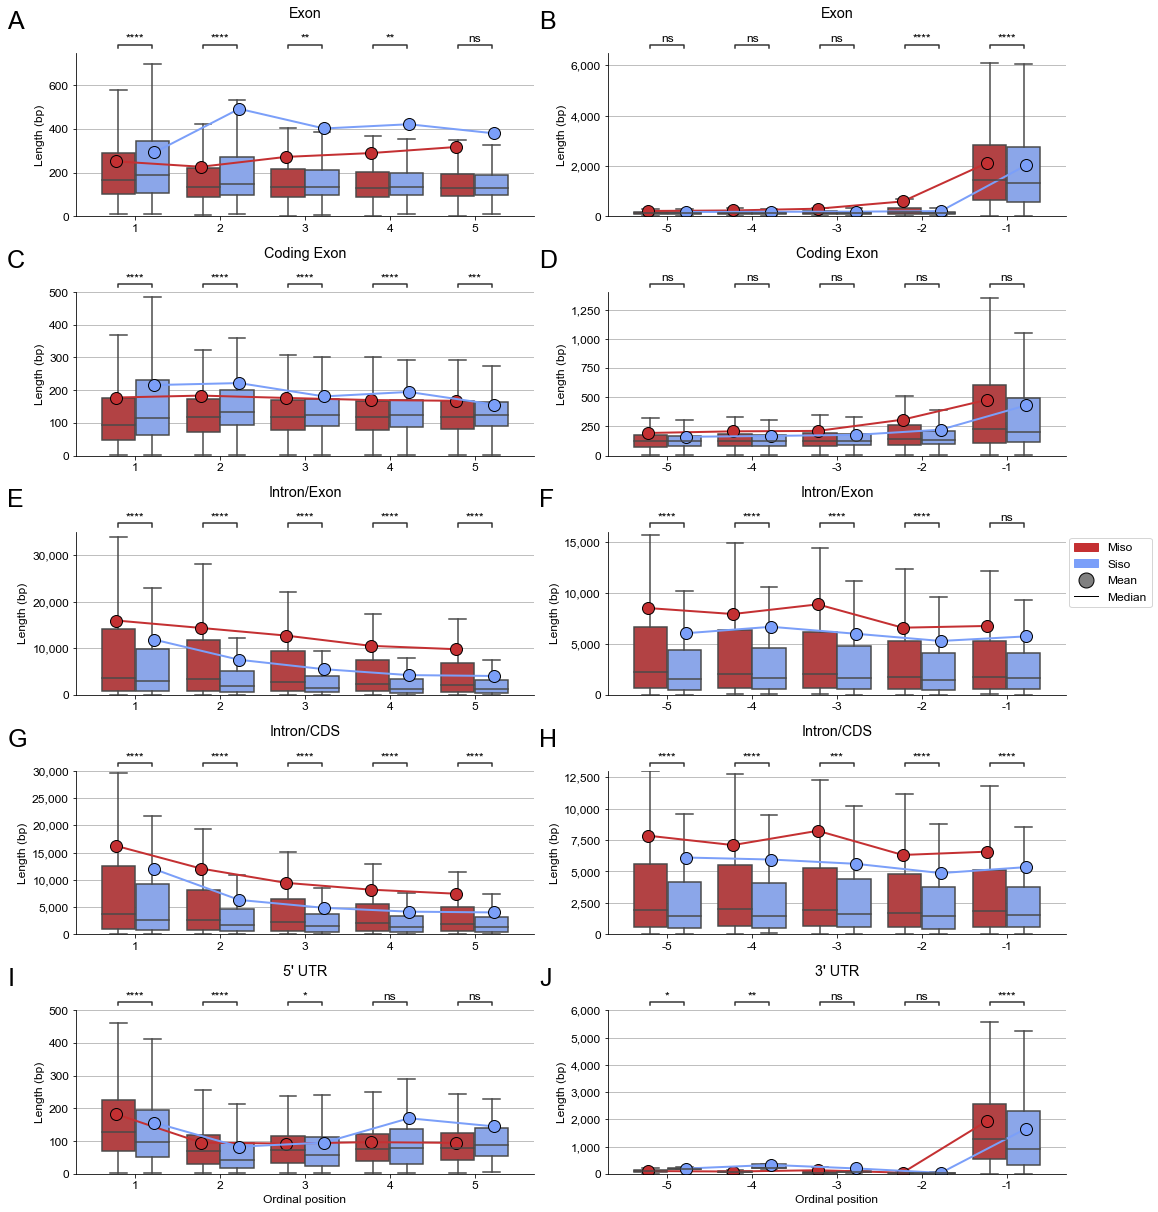

In [1416]:
f, ax = plt.subplots(nrows=5, ncols=2, figsize=(16,17))
palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in range(1,6)
]


tmp_exons_utr = pd.merge(pd.DataFrame(refseq_exons_utr.reset_index(drop=True).drop_duplicates(subset=['Gene', 'ranges']).groupby(['Gene'])['ranges'].count()), miso_siso[['Gene', 'Miso_siso']], on='Gene')
tmp_exons_utr_single_exon = tmp_exons_utr.loc[tmp_exons_utr['ranges'] == 1]['Gene'].values.tolist()


tmp_cds = pd.merge(pd.DataFrame(refseq_cds.reset_index(drop=True).drop_duplicates(subset=['Gene', 'ranges']).groupby(['Gene'])['ranges'].count()), miso_siso[['Gene', 'Miso_siso']], on='Gene')
tmp_cds_genes_single_cds = tmp_cds.loc[tmp_cds['ranges'] == 1]['Gene'].values.tolist()

zscore_cutoff = 1000

refseq_exons_utr_dd_plot = refseq_exons_utr_dd.loc[(refseq_exons_utr_dd['Exon_nb'] <= 5) & (~refseq_exons_utr_dd['Gene'].isin(tmp_exons_utr_single_exon))]
refseq_exons_utr_dd_plot_inverted = refseq_exons_utr_dd.loc[(refseq_exons_utr_dd['Exon_nb_inverted'] >= -5) & (~refseq_exons_utr_dd['Gene'].isin(tmp_exons_utr_single_exon))]

refseq_exons_utr_dd_plot['Z_length'] = scipy.stats.zscore(refseq_exons_utr_dd_plot['Length'])
refseq_exons_utr_dd_plot = refseq_exons_utr_dd_plot.loc[refseq_exons_utr_dd_plot['Z_length'] < zscore_cutoff]

refseq_cds_dd_plot = refseq_cds_dd.loc[(refseq_cds_dd['Exon_nb'] <= 5) & (~refseq_cds_dd['Gene'].isin(tmp_cds_genes_single_cds))]
refseq_cds_dd_plot_inverted = refseq_cds_dd_plot.loc[(refseq_cds_dd_plot['Exon_nb_inverted'] >= -5) & (~refseq_cds_dd_plot['Gene'].isin(tmp_exons_utr_single_exon))]


refseq_cds_dd_plot['Z_length'] = scipy.stats.zscore(refseq_cds_dd_plot['Length'])
refseq_cds_dd_plot = refseq_cds_dd_plot.loc[refseq_cds_dd_plot['Z_length'] < zscore_cutoff]
refseq_cds_dd_plot_single = refseq_cds_dd.loc[(refseq_cds_dd['Exon_nb'] <= 5) & (refseq_cds_dd['Gene'].isin(tmp_cds_genes_single_cds))]

refseq_exons_utr_introns_exploded_intron_nb_dd_plot = refseq_exons_utr_introns_exploded_intron_nb_dd.loc[(refseq_exons_utr_introns_exploded_intron_nb_dd['Intron_nb'] <= 5)  & (~refseq_exons_utr_introns_exploded_intron_nb_dd['Gene'].isin(tmp_exons_utr_single_exon))]
refseq_exons_utr_introns_exploded_intron_nb_dd_plot['Z_length'] = scipy.stats.zscore(refseq_exons_utr_introns_exploded_intron_nb_dd_plot['Intron_Length'])
refseq_exons_utr_introns_exploded_intron_nb_dd_plot = refseq_exons_utr_introns_exploded_intron_nb_dd_plot.loc[refseq_exons_utr_introns_exploded_intron_nb_dd_plot['Z_length'] < zscore_cutoff]

refseq_exons_utr_introns_exploded_intron_nb_dd_plot_inverted = refseq_exons_utr_introns_exploded_intron_nb_dd_plot.loc[(refseq_exons_utr_introns_exploded_intron_nb_dd_plot['Intron_nb_inverted'] >= -5) & (~refseq_exons_utr_introns_exploded_intron_nb_dd_plot['Gene'].isin(tmp_exons_utr_single_exon))]


refseq_cds_introns_exploded_intron_nb_dd_plot = refseq_cds_introns_exploded_intron_nb_dd.loc[(refseq_cds_introns_exploded_intron_nb_dd['Intron_nb'] <= 5)  & (~refseq_cds_introns_exploded_intron_nb_dd['Gene'].isin(tmp_exons_utr_single_exon))]
refseq_cds_introns_exploded_intron_nb_dd_plot['Z_length'] = scipy.stats.zscore(refseq_cds_introns_exploded_intron_nb_dd_plot['Intron_Length'])
refseq_cds_introns_exploded_intron_nb_dd_plot = refseq_cds_introns_exploded_intron_nb_dd_plot.loc[refseq_cds_introns_exploded_intron_nb_dd_plot['Z_length'] < zscore_cutoff]

refseq_cds_introns_exploded_intron_nb_dd_plot_inverted = refseq_cds_introns_exploded_intron_nb_dd_plot.loc[(refseq_cds_introns_exploded_intron_nb_dd_plot['Intron_nb_inverted'] >= -5) & (~refseq_cds_introns_exploded_intron_nb_dd_plot['Gene'].isin(tmp_exons_utr_single_exon))]


utrs_five_prime = utrs.loc[(utrs['UTR_bool'] == '5_prime') & (utrs['Nb_exon'] <= 5)]
utrs_five_prime['Nb_exon'] = utrs_five_prime['Nb_exon'].astype(int)

utrs_three_prime = utrs_test.loc[(utrs_test['UTR_bool'] == '3_prime') & (utrs_test['Nb_exon_inverted'] >= -5)]
utrs_three_prime['Nb_exon_inverted'] = utrs_three_prime['Nb_exon_inverted'].astype(int)

padding_title = 35

custom_boxplot(data=refseq_exons_utr_dd_plot, x='Exon_nb', y='Length', hue='Miso_siso', ax=ax[0][0], ylim=(0,750), palette=palette, title='Exon', box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=refseq_cds_dd_plot, x='Exon_nb', y='Length', hue='Miso_siso', ax=ax[1][0], ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title='Coding Exon', box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=refseq_exons_utr_introns_exploded_intron_nb_dd_plot, x='Intron_nb', y='Intron_Length', hue='Miso_siso', ax=ax[2][0], xlabel='', ylim=(0,35e3), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title='Intron/Exon', box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=refseq_cds_introns_exploded_intron_nb_dd_plot, x='Intron_nb', y='Intron_Length', hue='Miso_siso', ax=ax[3][0], xlabel='', ylim=(0,30e3), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title='Intron/CDS', box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=utrs_five_prime, x='Nb_exon', y='UTR_Length', hue='Miso_siso', ax=ax[4][0], xlabel='Ordinal position', ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' UTR", box_pairs=box_pairs, padding_title=padding_title)



box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in list(range(-5,0))
]


custom_boxplot(data=refseq_exons_utr_dd_plot_inverted, x='Exon_nb_inverted', y='Length', hue='Miso_siso', ax=ax[0][1], ylim=(0,6.5e3), palette=palette, title='Exon', box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=refseq_cds_dd_plot_inverted, x='Exon_nb_inverted', y='Length', hue='Miso_siso', ax=ax[1][1], ylim=(0,1.4e3), palette=palette, title='Coding Exon', box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=refseq_exons_utr_introns_exploded_intron_nb_dd_plot_inverted, x='Intron_nb_inverted', y='Intron_Length', hue='Miso_siso', ax=ax[2][1], ylim=(0,16e3), palette=palette, title='Intron/Exon', box_pairs=box_pairs, padding_title=padding_title, legend=True, x_legend=1.2,)
custom_boxplot(data=refseq_cds_introns_exploded_intron_nb_dd_plot_inverted, x='Intron_nb_inverted', y='Intron_Length', hue='Miso_siso', ax=ax[3][1], ylim=(0,13e3), palette=palette, title='Intron/CDS', box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=utrs_three_prime, x='Nb_exon_inverted', y='UTR_Length', hue='Miso_siso',  xlabel='Ordinal position', ax=ax[4][1], ylim=(0,6e3), palette=palette, title="3' UTR", box_pairs=box_pairs, padding_title=padding_title)

# custom_boxplot(data=refseq_cds_dd_plot_single, x='Exon_nb', y='Length', hue='Miso_siso', ax=ax[3], ylim=(0,3e3), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title='Coding Exon', box_pairs=box_pairs)




i = 0
for n, a in enumerate(ax):
    print(a)
    for sub_a in a:
#     print(sub_a)
        sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
        i += 1

plt.tight_layout()


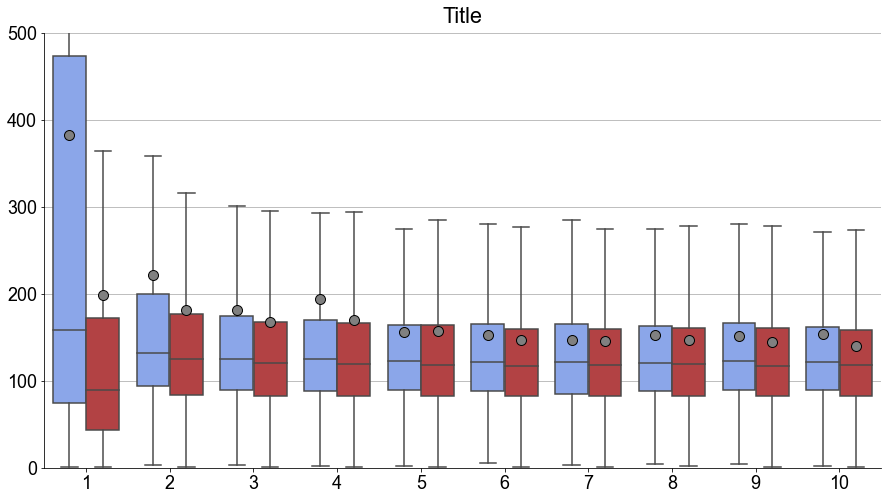

In [747]:
f, ax = plt.subplots(figsize=(15,8))
custom_boxplot(data=refseq_cds_dd.loc[refseq_cds_dd['Exon_nb'] <= 10], x='Exon_nb', y='Length', hue='Miso_siso', ax=ax, ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', })

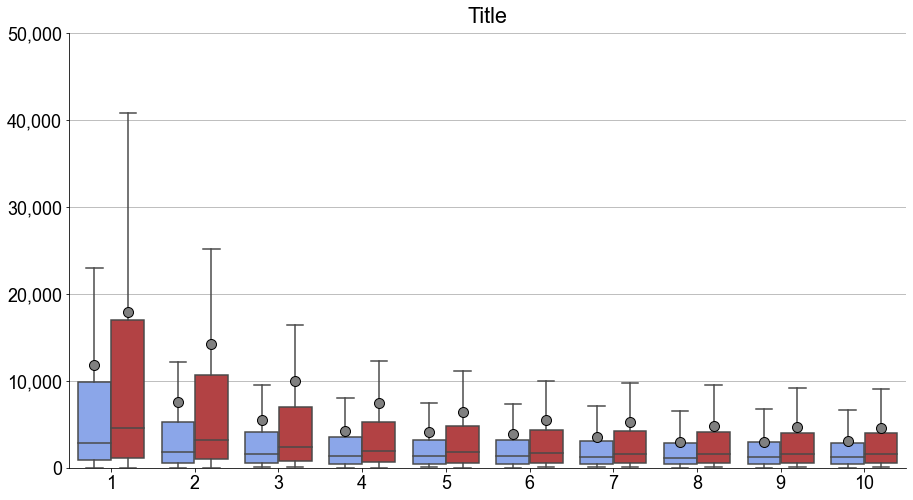

In [750]:
f, ax = plt.subplots(figsize=(15,8))
custom_boxplot(data=refseq_exons_utr_introns_exploded_intron_nb_dd.loc[refseq_exons_utr_introns_exploded_intron_nb_dd['Intron_nb'] <= 10], x='Intron_nb', y='Intron_Length', hue='Miso_siso', ax=ax, ylim=(0,50e3), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', })
